### KU ID: vfd881

In [364]:
import numpy as np
import sympy as sp
import scipy as sc
import matplotlib.pyplot as plt
import iminuit
import scipy.stats as stats
from IPython.display import display, Math, Latex
from scipy.integrate import quad
from scipy.stats import rv_continuous
from iminuit import Minuit, cost
from scipy import stats
from scipy.optimize import curve_fit, root_scalar
import pandas as pd

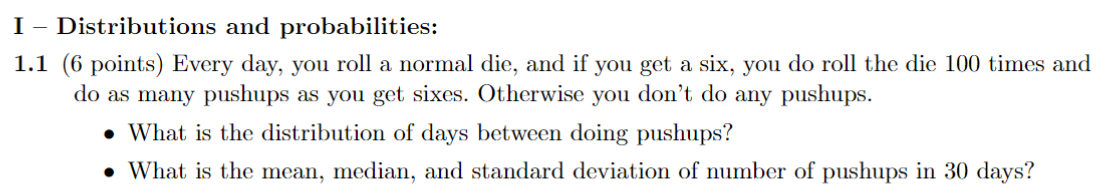

- Here I will use a geometric distribution, as it will give me the probaility of the first success happening on the nth trial. This I can use to plot the   distribution of the days it will take to get a six and therefore plot it.

- While the exact distribution of total pushups comes from a binomial distribution, the Central Limit Theorem (CLT) says that the sum of random variables (here, total pushups) often approaches a normal distribution. Therefore normal distribution provides a good approximation for the histogram

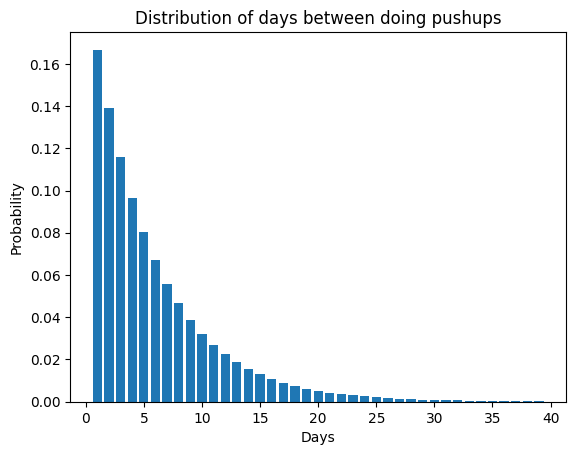

Mean number of pushups in 30 days: 83.654 
Standard deviation of number of pushups in 30 days: 35.94284746649881 
Median number of pushups in 30 days: 82.0


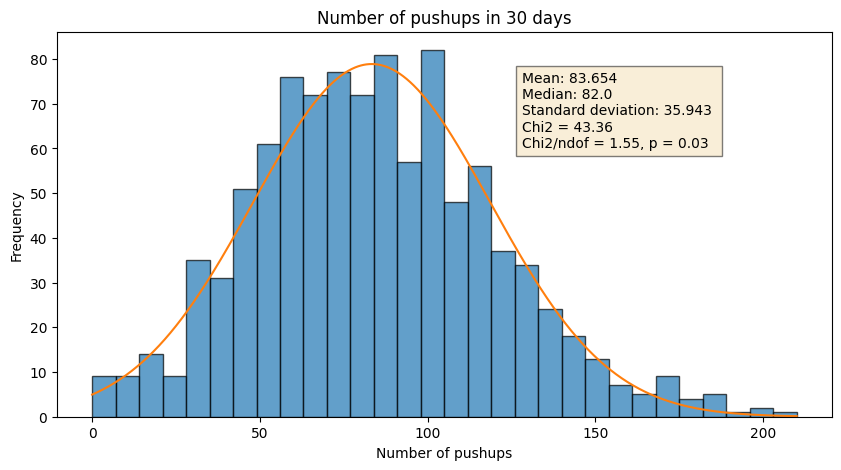

In [365]:
#Every day, you roll a normal die, and if you get a six, you do roll the die 100 times and do as many pushups as you get sixes. Otherwise you don’t do any pushups.
 
#What is the distribution of days between doing pushups

p = 1/6
n = 100
def prob(n):
    return (1-p)**(n-1)*p

x = np.arange(1, 40)
pmf = stats.geom.pmf(x, p)

plt.bar(x, pmf)
plt.xlabel('Days')
plt.ylabel('Probability')
plt.title('Distribution of days between doing pushups')
plt.show()

#What is the mean, median, and standard deviation of number of pushups in 30 days?
days = 30
die_rolls = 100

r = np.random.seed(42) #I set the seed so that the results are reproducible

total_pushups = []

for i in range(1000):
    daily_pushups = []
    for j in range(days):
        if np.random.rand() < p:
            daily_pushups.append(np.random.binomial(die_rolls, p))
        else:
            daily_pushups.append(0)
    total_pushups.append(sum(daily_pushups))

mean = np.mean(total_pushups)
median = np.median(total_pushups)
std = np.std(total_pushups)

print(f'Mean number of pushups in 30 days: {mean} \nStandard deviation of number of pushups in 30 days: {std} \nMedian number of pushups in 30 days: {median}')

# n = days*die_rolls
# binom_p = p/die_rolls #probability of getting a six in one roll
# binom_x =np.arange(min(total_pushups), max(total_pushups)+1)
# binom_pmf = stats.binom.pmf(binom_x, n, binom_p)




fig, ax = plt.subplots(figsize=(10, 5))
counts, edges, _ = plt.hist(total_pushups, bins=30, range=(min(total_pushups), max(total_pushups)) ,edgecolor='black', alpha=0.7)
# counts, edges = np.histogram(total_pushups, bins=30, range=(min(total_pushups), max(total_pushups)), density=True)
x = (edges[1:] + edges[:-1])/2
x = x[counts > 0]
y = counts[counts > 0]
y_err = np.sqrt(y)

xmax = max(total_pushups)
xmin = min(total_pushups)

def gauss(x, mean, std):
    k = (xmax-xmin)/30
    N = 1000*k
    return N*stats.norm.pdf(x, mean, std)

# ax.errorbar(x, y, y_err, fmt='o', color='black', label='Histogram of number of pushups')

fit = cost.LeastSquares(x, y, y_err, gauss)
m = Minuit(fit, mean=mean, std=std)
m.migrad()

chi2 =m.fval
ndof = len(x) - len(m.values)
p_value = stats.chi2.sf(chi2, ndof)

x_gauss = np.linspace(min(total_pushups), max(total_pushups), 1000)
y_gauss = gauss(x_gauss, m.values['mean'], m.values['std'])

ax.plot(x_gauss, y_gauss, label='Normal distribution')
# ax.hist(total_pushups, bins=30, edgecolor='black', density=True, alpha=0.7, label='Histogram of number of pushups')
ax.text(0.6, 0.7, f'Mean: {mean}\nMedian: {median}\nStandard deviation: {std:.3f} \nChi2 = {chi2:.2f} \nChi2/ndof = {chi2/ndof:.2f}, p = {p_value:.2f} ', transform=ax.transAxes,
    bbox=dict(facecolor='wheat', alpha=0.5))
ax.set_xlabel('Number of pushups')
ax.set_ylabel('Frequency')
ax.set_title('Number of pushups in 30 days')
plt.show()


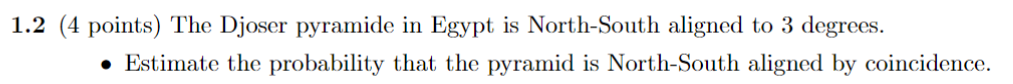

If it's by coincidence then I can assume a uniform probability distribution of angles it could be alligned with over 360 degrees. I will run a simulation to see how many fall in the range of 3 degrees

In [366]:
Degrees = 360
range_angle = 6
simulation = 1000

aligned = []

for i in range(simulation):
    random_angle = np.random.uniform(0, Degrees)
    if random_angle < range_angle:
        aligned.append(1)
    else:
        aligned.append(0)

prob = sum(aligned)/simulation
print(f'Probability of being aligned by coincidence: {prob}')


Probability of being aligned by coincidence: 0.021


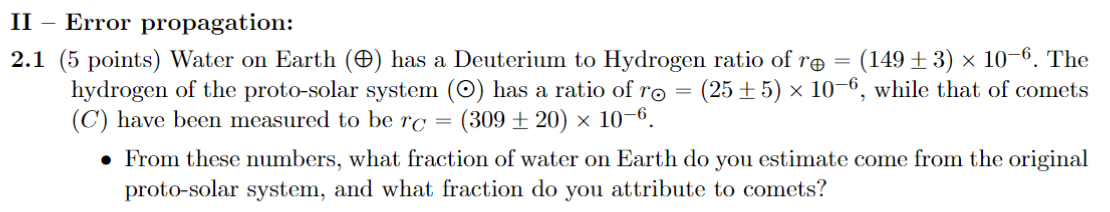

To do this I assume a linear correlation between the ratio of water on earth and the ratios of water coming from the protosolar system and the comet.

$ r_E = f_p \cdot r_p + f_c \cdot r_c $

where $ r_E $ is the ratio of water on earth, $ f_p $ is the fraction of water coming from the protosolar system, $ r_p $ is the ratio of water in the protosolar system, $ f_c $ is the fraction of water coming from the comet, and $ r_c $ is the ratio of water in the comet.

This also means:

$ f_p + f_c = 1 $

$ r_E = f_p \cdot r_p + (1 - f_p) \cdot r_c $

$ f_p = \frac{r_c - r_E}{r_c - r_p} $

$ f_c = 1 - f_p $

In [367]:
r_E = 149e-6
r_E_err = 3e-6

r_P = 25e-6
r_P_err = 5e-6

r_C = 309e-6
r_C_err = 20e-6

f_p = (r_C - r_E)/(r_C - r_P) #Fraction from proto-solar
f_C = 1 - f_p #Fraction from comet

f_p_error = np.sqrt((r_E_err/(r_C -r_P))**2 + (r_C_err*(r_E -r_P)/(r_C - r_P)**2)**2 + r_P_err*(r_C - r_E)/(r_C - r_P)**2)
f_C_error = np.sqrt((r_E_err/(r_C -r_P))**2 + (r_C_err*(r_P -r_E)/(r_C - r_P)**2)**2 + r_P_err*(r_C - r_P)/(r_C - r_P)**2)

print(f'Fraction of proto-solar material: {f_p:.3f} ± {f_p_error:.3f} \nFraction of comet material: {f_C:.3f} ± {f_C_error:.3f}')

Fraction of proto-solar material: 0.563 ± 0.105 
Fraction of comet material: 0.437 ± 0.137


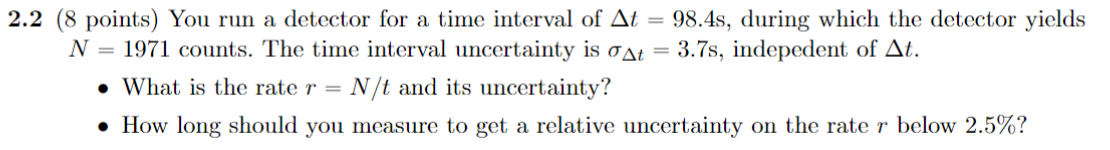

For the uncertainty on the counts I assume it follows a poisson distribution, and the error will be square root of the counts.

In [368]:
t = 98.4
t_err = 3.7
N = 1971
N_err = np.sqrt(N)

r = N/t
r_err = np.sqrt((N_err/t)**2 + (N*t_err/t**2)**2)
print(f'Rate of decay: {r:.3f} ± {r_err:.3f} decays/s')
print(f'Relative error of rate of decay: {r_err/r:.3f}')

Rate of decay: 20.030 ± 0.878 decays/s
Relative error of rate of decay: 0.044


I will run a simulation over a range of t's to see how the error changes with the counts and find when the relative error is less than 2.5%. I will start at t = 98.4, since I know that gives a relative rate of 4.4%. I will do in stepsizes of 0.1 s

$ \frac{\sigma_r}{r} < 0.025 $

In [369]:
def relative_err(t_guess):
    return (np.sqrt((N_err/t_guess)**2 + (N*t_err/t_guess**2)**2)*t_guess)/N

rel_error = 1
t_range = np.arange(98.4, 500, 0.1)
i = 0
for i in range(len(t_range)):
    rel_error = relative_err(t_range[i])
    if rel_error < 0.025:
        print(f'The time needed for a relative error of 2.5% is: {t_range[i]:.1f} s')
        print(f'The relative error at this time is: {rel_error:.3f}')
        break



The time needed for a relative error of 2.5% is: 341.2 s
The relative error at this time is: 0.025


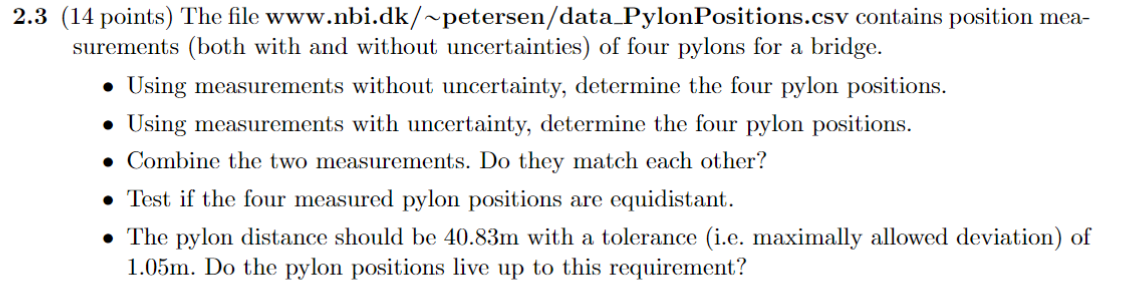

(80, 2)
(40, 2)


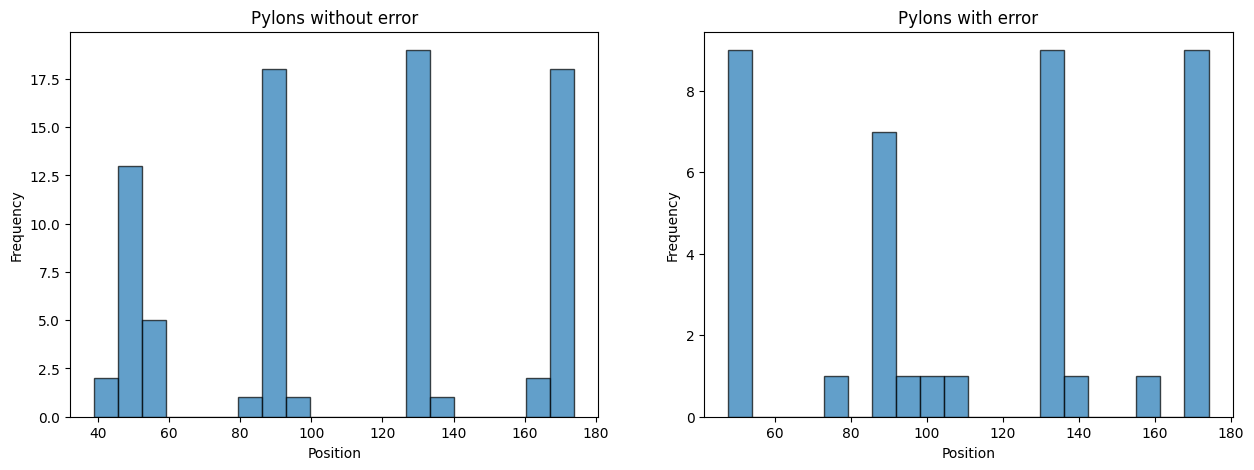

In [370]:
Pylons = pd.read_csv('data_PylonPositions.csv')
Pylons_no_err = Pylons[Pylons['  Uncertainty'] == -1]
Pylons_w_err = Pylons[Pylons['  Uncertainty'] != -1]

print(Pylons_no_err.shape)
print(Pylons_w_err.shape)

fig,ax = plt.subplots(1,2,figsize=(15, 5))
ax[0].hist(Pylons_no_err['# Position'], bins=20, edgecolor='black', alpha=0.7, label='Pylons without error')
ax[1].hist(Pylons_w_err['# Position'], bins=20, edgecolor='black', alpha=0.7, label='Pylons with error')
ax[0].set_xlabel('Position')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Pylons without error')
ax[1].set_xlabel('Position')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Pylons with error')
plt.show()




I will start with the pylons without error, where it is very easy to see the 4 pylons as seen on the histogram. As they don't have any uncertainty, I will simply take the mean of the 4 peaks as the position of the pylons. Furthermore I will use chauvenet's criterion to remove the outliers, if there is any. To do this I will use student's t-distribution to test for outliers as the varience is unknown and N is small. I set my criterion for the t-test to have to be less than 0.25 for me to remove the data point.

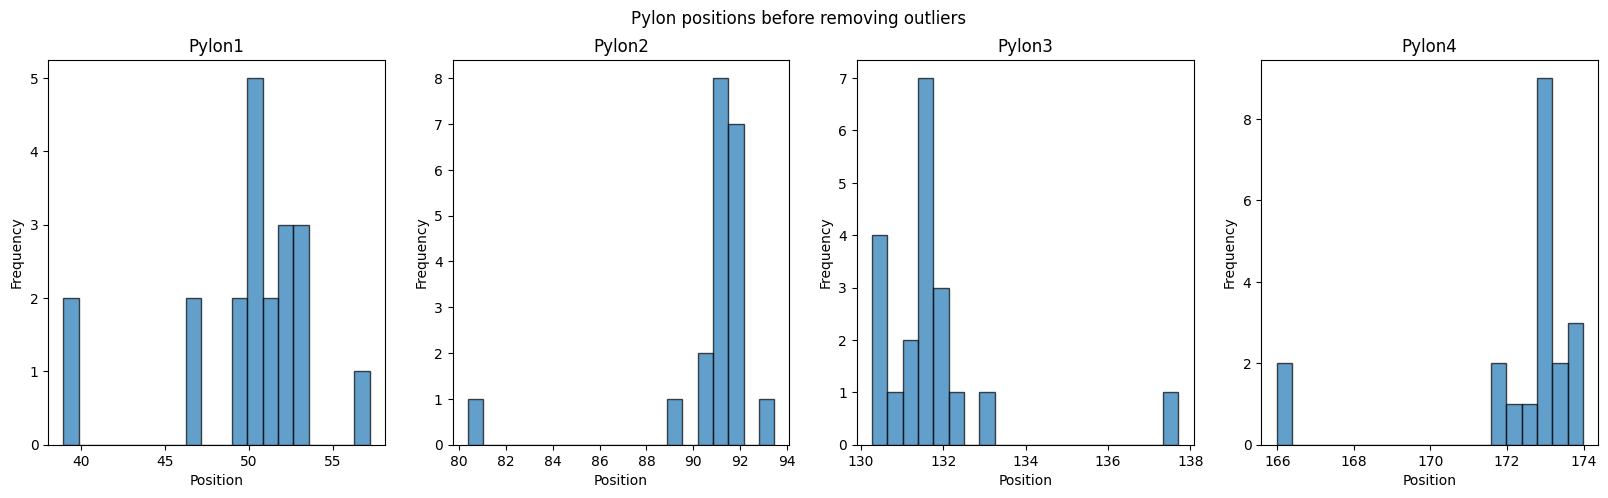

Good data in Pylon1: 17 
Bad data in Pylon1: 3
Good data in Pylon2: 17 
Bad data in Pylon2: 3
Good data in Pylon3: 19 
Bad data in Pylon3: 1
Good data in Pylon4: 18 
Bad data in Pylon4: 2
Pylon1 position: 50.75 ± 0.47 
Pylon2 position: 91.30 ± 0.12 
Pylon3 position: 131.47 ± 0.16 
Pylon4 position: 172.95 ± 0.14


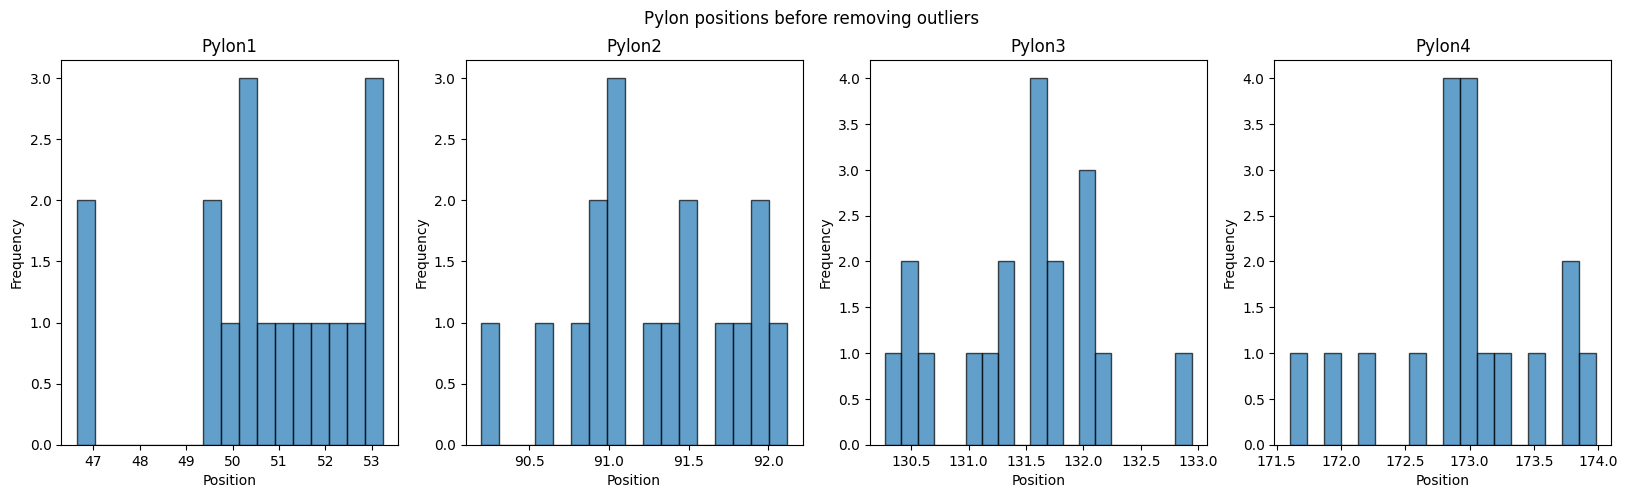

In [371]:
Pylon1_no_error = Pylons_no_err['# Position'][Pylons_no_err['# Position'] < 70]
Pylon2_no_error = Pylons_no_err['# Position'][(Pylons_no_err['# Position'] > 70) & (Pylons_no_err['# Position'] < 110)]
Pylon3_no_error = Pylons_no_err['# Position'][(Pylons_no_err['# Position'] > 110) & (Pylons_no_err['# Position'] < 150)]
Pylon4_no_error = Pylons_no_err['# Position'][Pylons_no_err['# Position'] > 150]

fig,ax = plt.subplots(1,4,figsize=(20, 5))
ax[0].hist(Pylon1_no_error, bins=20, edgecolor='black', alpha=0.7, label='Pylon1')   
ax[1].hist(Pylon2_no_error, bins=20, edgecolor='black', alpha=0.7, label='Pylon2')
ax[2].hist(Pylon3_no_error, bins=20, edgecolor='black', alpha=0.7, label='Pylon3')
ax[3].hist(Pylon4_no_error, bins=20, edgecolor='black', alpha=0.7, label='Pylon4')
ax[0].set_xlabel('Position')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Pylon1')
ax[1].set_xlabel('Position')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Pylon2')
ax[2].set_xlabel('Position')
ax[2].set_ylabel('Frequency')
ax[2].set_title('Pylon3')
ax[3].set_xlabel('Position')
ax[3].set_ylabel('Frequency')
ax[3].set_title('Pylon4')
fig.suptitle('Pylon positions before removing outliers')
plt.show()

def chauvenet(data):
    bad_data = []
    good_data = np.array(data)
    check = True
    while check:
        N = len(good_data)
        mean = good_data.mean()
        std = good_data.std(ddof=1)
        # z = N*sc.special.erfc(abs(good_data-mean)/(std))
        t = N*stats.t.sf(abs(good_data-mean)/(std), N-1)
        p = stats.norm.sf(t)
        idx = np.argmin(t)
        # print(p[idx])
        # print(z[idx])
        if t[idx] < 0.25:
            bad_data.append(good_data[idx])
            good_data = np.delete(good_data, idx)
        else:
            check = False
    return good_data, bad_data

Pylon1_good, Pylon1_bad = chauvenet(Pylon1_no_error)
Pylon2_good, Pylon2_bad = chauvenet(Pylon2_no_error)
Pylon3_good, Pylon3_bad = chauvenet(Pylon3_no_error)
Pylon4_good, Pylon4_bad = chauvenet(Pylon4_no_error)
print(f'Good data in Pylon1: {len(Pylon1_good)} \nBad data in Pylon1: {len(Pylon1_bad)}')
print(f'Good data in Pylon2: {len(Pylon2_good)} \nBad data in Pylon2: {len(Pylon2_bad)}')
print(f'Good data in Pylon3: {len(Pylon3_good)} \nBad data in Pylon3: {len(Pylon3_bad)}')
print(f'Good data in Pylon4: {len(Pylon4_good)} \nBad data in Pylon4: {len(Pylon4_bad)}')

Pylon1_pos_no_error = np.mean(Pylon1_good)
Pylon1_pos_no_error_err = np.std(Pylon1_good)/np.sqrt(len(Pylon1_good))

Pylon2_pos_no_error  = np.mean(Pylon2_good)
Pylon2_pos_no_error_err = np.std(Pylon2_good)/np.sqrt(len(Pylon2_good))

Pylon3_pos_no_error  = np.mean(Pylon3_good)
Pylon3_pos_no_error_err = np.std(Pylon3_good)/np.sqrt(len(Pylon3_good))

Pylon4_pos_no_error  = np.mean(Pylon4_good)
Pylon4_pos_no_error_err = np.std(Pylon4_good)/np.sqrt(len(Pylon4_good))

print(f'Pylon1 position: {Pylon1_pos_no_error :.2f} ± {Pylon1_pos_no_error_err:.2f} \nPylon2 position: {Pylon2_pos_no_error:.2f} ± {Pylon2_pos_no_error_err:.2f} \nPylon3 position: {Pylon3_pos_no_error:.2f} ± {Pylon3_pos_no_error_err:.2f} \nPylon4 position: {Pylon4_pos_no_error:.2f} ± {Pylon4_pos_no_error_err:.2f}')

fig,ax = plt.subplots(1,4,figsize=(20, 5))
ax[0].hist(Pylon1_good, bins=len(Pylon1_good), edgecolor='black', alpha=0.7, label='Pylon1')   
ax[1].hist(Pylon2_good, bins=len(Pylon2_good), edgecolor='black', alpha=0.7, label='Pylon2')
ax[2].hist(Pylon3_good, bins=len(Pylon3_good), edgecolor='black', alpha=0.7, label='Pylon3')
ax[3].hist(Pylon4_good, bins=len(Pylon4_good), edgecolor='black', alpha=0.7, label='Pylon4')
ax[0].set_xlabel('Position')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Pylon1')
ax[1].set_xlabel('Position')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Pylon2')
ax[2].set_xlabel('Position')
ax[2].set_ylabel('Frequency')
ax[2].set_title('Pylon3')
ax[3].set_xlabel('Position')
ax[3].set_ylabel('Frequency')
ax[3].set_title('Pylon4')
fig.suptitle('Pylon positions before removing outliers')
plt.show()


(40,)


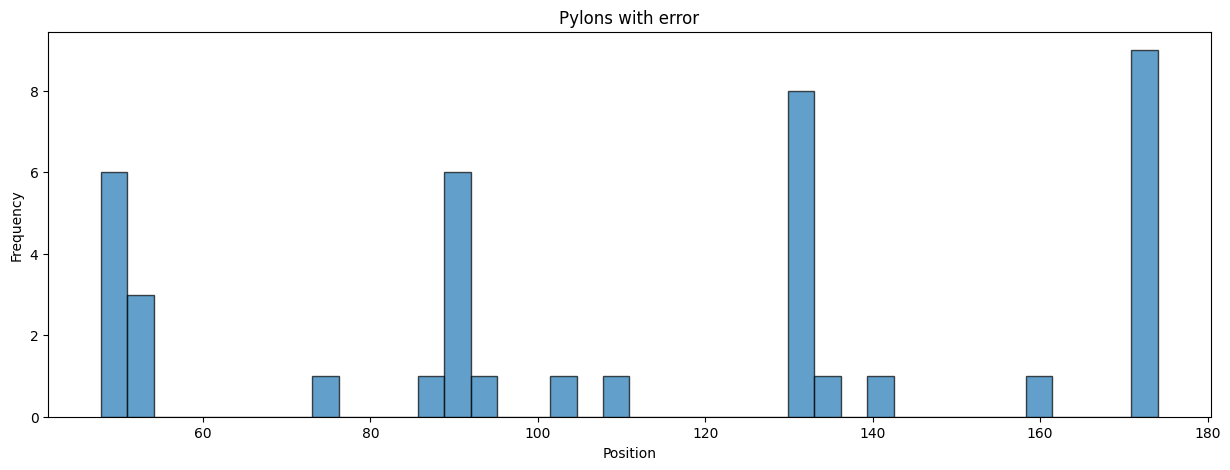

In [372]:
print(Pylons_w_err['# Position'].shape)
fig,ax = plt.subplots(figsize=(15, 5))
ax.hist(Pylons_w_err['# Position'], bins=40, edgecolor='black', alpha=0.7, label='Pylons with error')
ax.set_xlabel('Position')
ax.set_ylabel('Frequency')
ax.set_title('Pylons with error')
plt.show()

To start with I will use the same range assumed for the ones without uncertainty

In [373]:
def weighted(values, errors):
    values = np.array(values)
    errors = np.array(errors)
    weights = 1 / errors**2  # Using p.83 in Barlow
    result = np.sum(values / errors**2) / np.sum(weights)
    error = 1 / np.sqrt(np.sum(weights))
    # error = error* np.sqrt(np.sum(weights**2)) # This is if the data is  independent and identically distributed random variables
    return result, error

def mean_value(x, mean):
    return np.ones_like(x)*mean

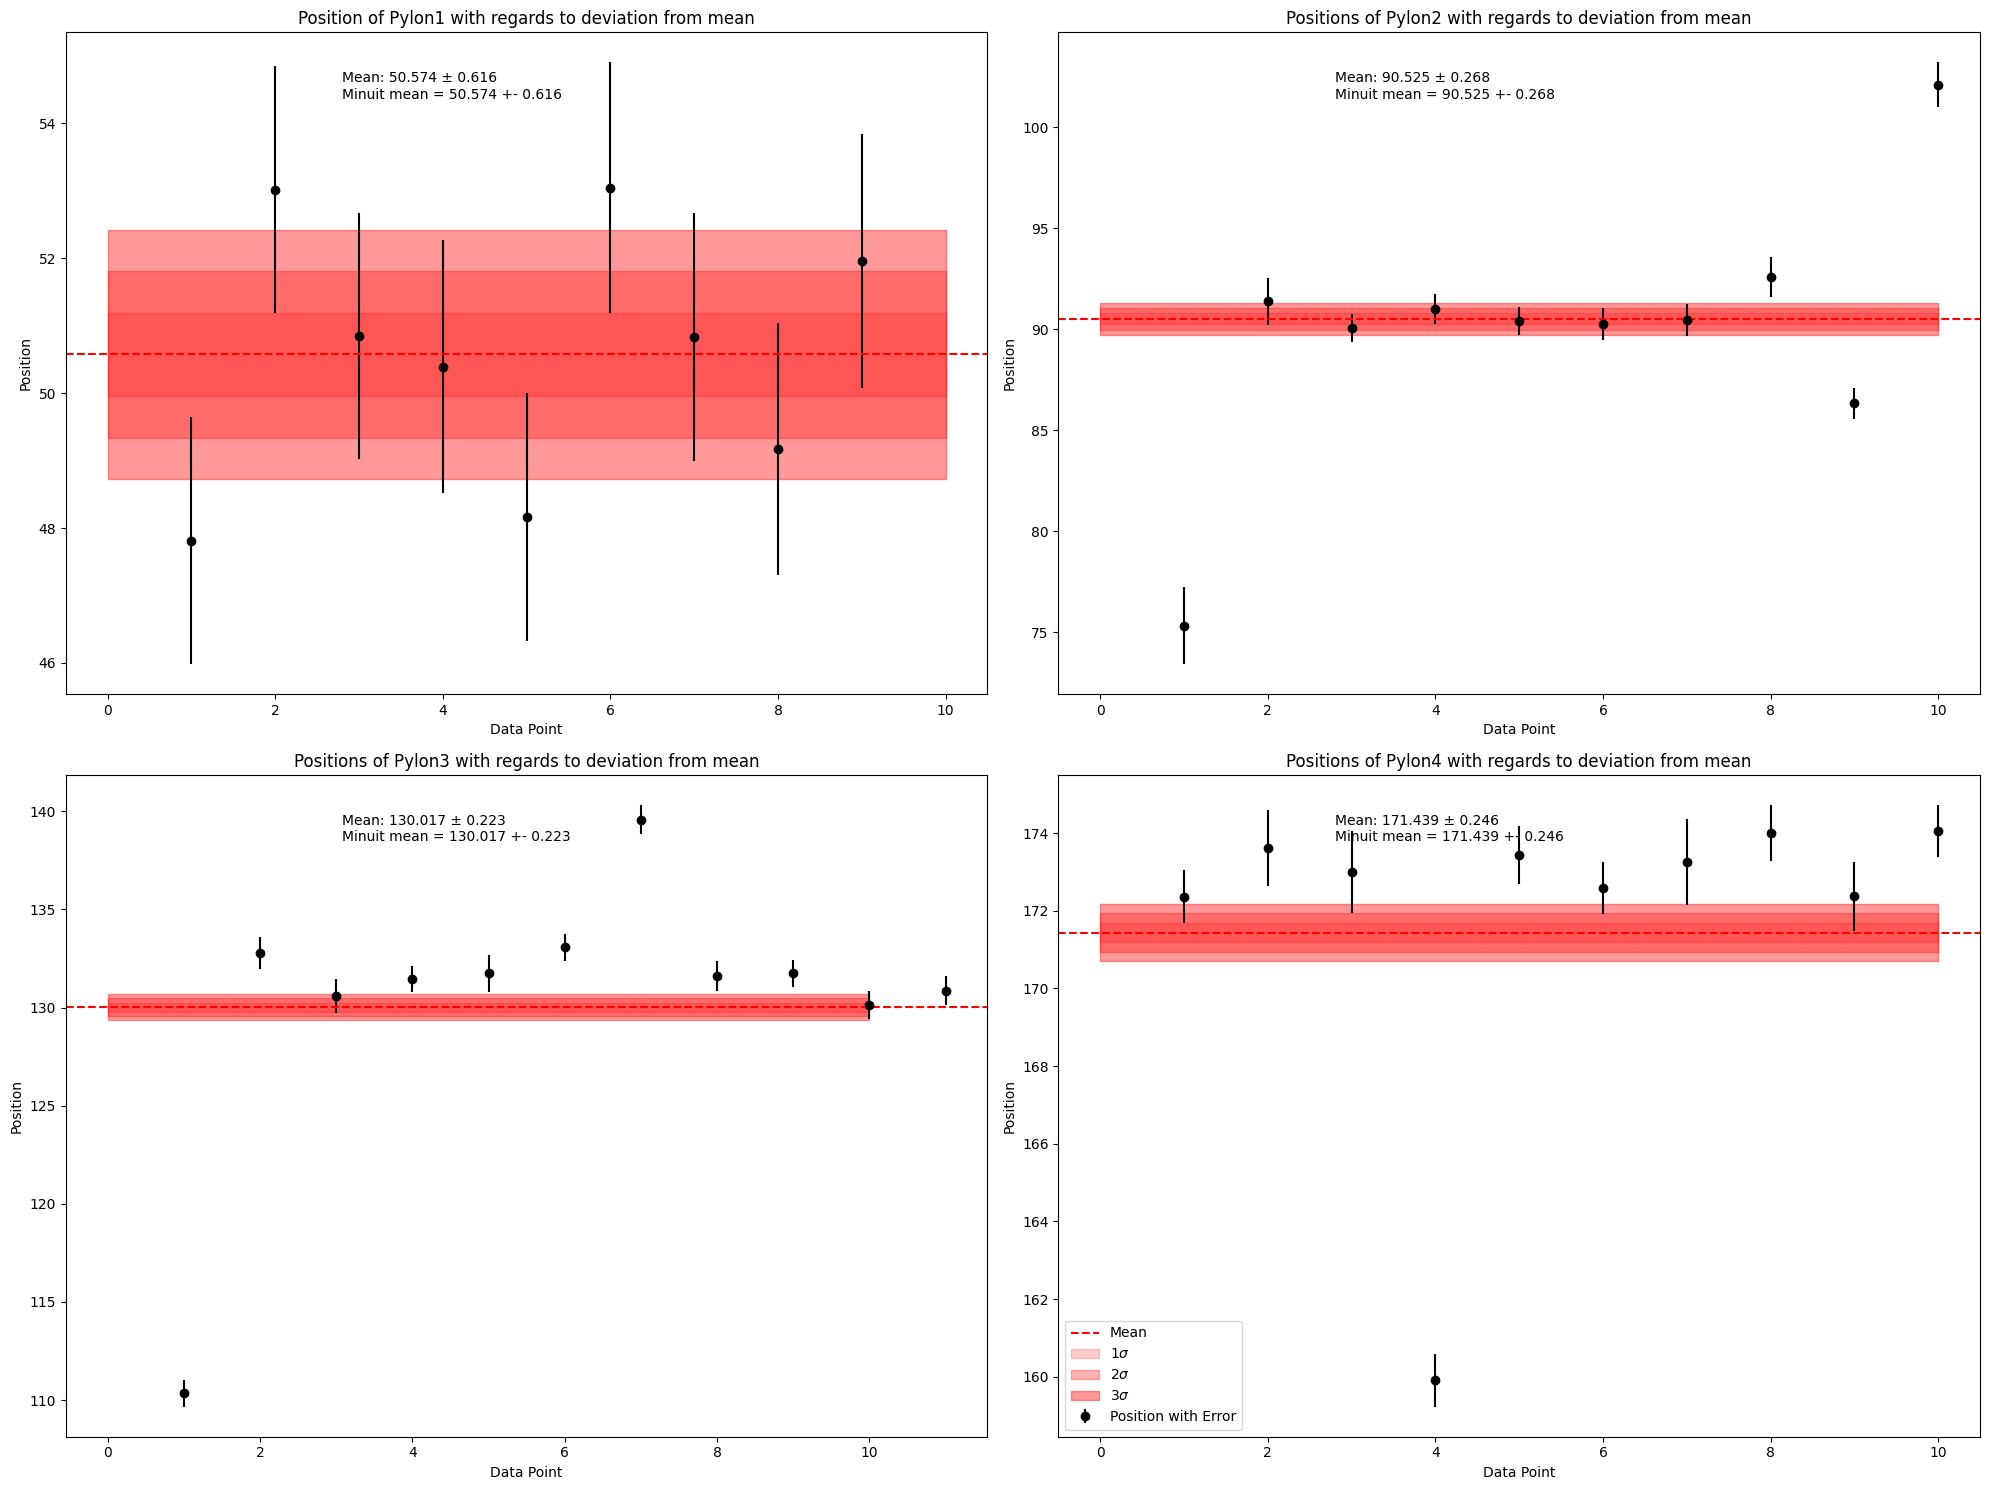

In [374]:
Pylon1_w_error = Pylons_w_err['# Position'][Pylons_w_err['# Position'] < 70]
Pylon1_err = Pylons_w_err['  Uncertainty'][Pylons_w_err['# Position'] < 70]

Pylon2_w_error = Pylons_w_err['# Position'][(Pylons_w_err['# Position'] > 70) & (Pylons_w_err['# Position'] < 110)]
Pylon2_err = Pylons_w_err['  Uncertainty'][(Pylons_w_err['# Position'] > 70) & (Pylons_w_err['# Position'] < 110)]

Pylon3_w_error = Pylons_w_err['# Position'][(Pylons_w_err['# Position'] > 110) & (Pylons_w_err['# Position'] < 150)]
Pylon3_err = Pylons_w_err['  Uncertainty'][(Pylons_w_err['# Position'] > 110) & (Pylons_w_err['# Position'] < 150)]

Pylon4_w_error = Pylons_w_err['# Position'][Pylons_w_err['# Position'] > 150]
Pylon4_err = Pylons_w_err['  Uncertainty'][Pylons_w_err['# Position'] > 150]

Pylon1_pos, Pylon1_pos_err = weighted(Pylon1_w_error, Pylon1_err)

chi2_fit = cost.LeastSquares(np.ones_like(Pylon1_w_error), Pylon1_w_error, Pylon1_err, mean_value)
m = Minuit(chi2_fit, mean=Pylon1_pos)
m.migrad()
minuit_mean = m.values['mean']
minuit_mean_err = m.errors['mean']


fig,ax = plt.subplots(2,2,figsize=(20, 15))
ax[0,0].errorbar(np.arange(len(Pylon1_w_error)) +1 , Pylon1_w_error, yerr=Pylon1_err, fmt='o', color='black', label='Position with Error')
ax[0,0].axhline(Pylon1_pos, color='red', linestyle='--', label='Mean')
ax[0,0].fill_between([0, 10], Pylon1_pos-Pylon1_pos_err, Pylon1_pos+Pylon1_pos_err, color='red', alpha=0.2, label='1$\sigma$')
ax[0,0].fill_between([0, 10], Pylon1_pos-2*Pylon1_pos_err, Pylon1_pos+2*Pylon1_pos_err, color='red', alpha=0.3, label='2$\sigma$')
ax[0,0].fill_between([0, 10], Pylon1_pos-3*Pylon1_pos_err, Pylon1_pos+3*Pylon1_pos_err, color='red', alpha=0.4, label='3$\sigma$')
ax[0,0].text(0.3, 0.9, f'Mean: {Pylon1_pos:.3f} ± {Pylon1_pos_err:.3f} \nMinuit mean = {minuit_mean:.3f} +- {minuit_mean_err:.3f}', transform=ax[0,0].transAxes)
ax[0,0].set_xlabel('Data Point')
ax[0,0].set_ylabel('Position')
ax[0,0].set_title('Position of Pylon1 with regards to deviation from mean')
# plt.legend()
# plt.tight_layout()
# plt.show()

Pylon2_pos, Pylon2_pos_err = weighted(Pylon2_w_error, Pylon2_err)

chi2_fit = cost.LeastSquares(np.ones_like(Pylon2_w_error), Pylon2_w_error, Pylon2_err, mean_value)
m = Minuit(chi2_fit, mean=Pylon2_pos)
m.migrad()
minuit_mean = m.values['mean']
minuit_mean_err = m.errors['mean']


# fig,ax = plt.subplots(figsize=(10, 5))
ax[0,1].errorbar(np.arange(len(Pylon2_w_error)) +1 , Pylon2_w_error, yerr=Pylon2_err, fmt='o', color='black', label='Position with Error')
ax[0,1].axhline(Pylon2_pos, color='red', linestyle='--', label='Mean')
ax[0,1].fill_between([0, 10], Pylon2_pos-Pylon2_pos_err, Pylon2_pos+Pylon2_pos_err, color='red', alpha=0.2, label='1$\sigma$')
ax[0,1].fill_between([0, 10], Pylon2_pos-2*Pylon2_pos_err, Pylon2_pos+2*Pylon2_pos_err, color='red', alpha=0.3, label='2$\sigma$')
ax[0,1].fill_between([0, 10], Pylon2_pos-3*Pylon2_pos_err, Pylon2_pos+3*Pylon2_pos_err, color='red', alpha=0.4, label='3$\sigma$')
ax[0,1].text(0.3, 0.9, f'Mean: {Pylon2_pos:.3f} ± {Pylon2_pos_err:.3f} \nMinuit mean = {minuit_mean:.3f} +- {minuit_mean_err:.3f}', transform=ax[0,1].transAxes)
ax[0,1].set_xlabel('Data Point')
ax[0,1].set_ylabel('Position')
ax[0,1].set_title('Positions of Pylon2 with regards to deviation from mean')

Pylon3_pos, Pylon3_pos_err = weighted(Pylon3_w_error, Pylon3_err)

chi2_fit = cost.LeastSquares(np.ones_like(Pylon3_w_error), Pylon3_w_error, Pylon3_err, mean_value)

m = Minuit(chi2_fit, mean=Pylon3_pos)
m.migrad()
minuit_mean = m.values['mean']
minuit_mean_err = m.errors['mean']

# fig,ax = plt.subplots(figsize=(10, 5))
ax[1,0].errorbar(np.arange(len(Pylon3_w_error)) +1 , Pylon3_w_error, yerr=Pylon3_err, fmt='o', color='black', label='Position with Error')
ax[1,0].axhline(Pylon3_pos, color='red', linestyle='--', label='Mean')
ax[1,0].fill_between([0, 10], Pylon3_pos-Pylon3_pos_err, Pylon3_pos+Pylon3_pos_err, color='red', alpha=0.2, label='1$\sigma$')
ax[1,0].fill_between([0, 10], Pylon3_pos-2*Pylon3_pos_err, Pylon3_pos+2*Pylon3_pos_err, color='red', alpha=0.3, label='2$\sigma$')
ax[1,0].fill_between([0, 10], Pylon3_pos-3*Pylon3_pos_err, Pylon3_pos+3*Pylon3_pos_err, color='red', alpha=0.4, label='3$\sigma$')
ax[1,0].text(0.3, 0.9, f'Mean: {Pylon3_pos:.3f} ± {Pylon3_pos_err:.3f} \nMinuit mean = {minuit_mean:.3f} +- {minuit_mean_err:.3f}', transform=ax[1,0].transAxes)
ax[1,0].set_xlabel('Data Point')
ax[1,0].set_ylabel('Position')
ax[1,0].set_title('Positions of Pylon3 with regards to deviation from mean')

Pylon4_pos, Pylon4_pos_err = weighted(Pylon4_w_error, Pylon4_err)

chi2_fit = cost.LeastSquares(np.ones_like(Pylon4_w_error), Pylon4_w_error, Pylon4_err, mean_value)
m = Minuit(chi2_fit, mean=Pylon4_pos)
m.migrad()
minuit_mean = m.values['mean']
minuit_mean_err = m.errors['mean']

# fig,ax = plt.subplots(figsize=(10, 5))
ax[1,1].errorbar(np.arange(len(Pylon4_w_error)) +1 , Pylon4_w_error, yerr=Pylon4_err, fmt='o', color='black', label='Position with Error')
ax[1,1].axhline(Pylon4_pos, color='red', linestyle='--', label='Mean')
ax[1,1].fill_between([0, 10], Pylon4_pos-Pylon4_pos_err, Pylon4_pos+Pylon4_pos_err, color='red', alpha=0.2, label='1$\sigma$')
ax[1,1].fill_between([0, 10], Pylon4_pos-2*Pylon4_pos_err, Pylon4_pos+2*Pylon4_pos_err, color='red', alpha=0.3, label='2$\sigma$')
ax[1,1].fill_between([0, 10], Pylon4_pos-3*Pylon4_pos_err, Pylon4_pos+3*Pylon4_pos_err, color='red', alpha=0.4, label='3$\sigma$')
ax[1,1].text(0.3, 0.9, f'Mean: {Pylon4_pos:.3f} ± {Pylon4_pos_err:.3f} \nMinuit mean = {minuit_mean:.3f} +- {minuit_mean_err:.3f}', transform=ax[1,1].transAxes)
ax[1,1].set_xlabel('Data Point')
ax[1,1].set_ylabel('Position')
ax[1,1].set_title('Positions of Pylon4 with regards to deviation from mean')

plt.legend()
plt.tight_layout()
plt.show()

def Errorbar(pylon_pos, Pylon_pos_err,Name):
    Pylon_pos_avg, Pylon_pos_err_avg = weighted(pylon_pos, Pylon_pos_err)

    chi2_fit = cost.LeastSquares(np.ones_like(pylon_pos), pylon_pos, Pylon_pos_err, mean_value)
    m = Minuit(chi2_fit, mean=Pylon_pos_avg)
    m.migrad()
    minuit_mean = m.values['mean']
    minuit_mean_err = m.errors['mean']

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.errorbar(np.arange(len(pylon_pos)) +1 , pylon_pos, yerr=Pylon_pos_err, fmt='o', color='black', label='Position with Error')
    ax.axhline(Pylon_pos_avg, color='red', linestyle='--', label='Mean')
    ax.fill_between([0, 10], Pylon_pos_avg-Pylon_pos_err_avg, Pylon_pos_avg+Pylon_pos_err_avg, color='red', alpha=0.2, label='1$\sigma$')
    ax.fill_between([0, 10], Pylon_pos_avg-2*Pylon_pos_err_avg, Pylon_pos_avg+2*Pylon_pos_err_avg, color='red', alpha=0.3, label='2$\sigma$')
    ax.fill_between([0, 10], Pylon_pos_avg-3*Pylon_pos_err_avg, Pylon_pos_avg+3*Pylon_pos_err_avg, color='red', alpha=0.4, label='3$\sigma$')
    ax.text(0.3, 0.9, f'Mean: {Pylon_pos_avg:.3f} ± {Pylon_pos_err_avg:.3f} \nMinuit mean = {minuit_mean:.3f} +- {minuit_mean_err:.3f}', transform=ax.transAxes)
    ax.set_xlabel('Data Point')
    ax.set_ylabel('Position')
    ax.set_title(f'Positions of {Name} with regards to deviation from mean')
    plt.legend()
    plt.tight_layout()
    plt.show()
    print(f'{Name} position after removing outliers: {Pylon_pos_avg:.2f} ± {Pylon_pos_err_avg:.2f}')
    return Pylon_pos_avg, Pylon_pos_err_avg

    
    


For Pylon 1 it seems that all points are withing 3 sigma of the mean, so I will not remove any points. For the others I will start removing the furthest points and see if the change to the mean will affect the other points. I will do this iteratively until I have removed all the outliers.

In [375]:
Pylon2_w_error = Pylon2_w_error.drop(Pylon2_w_error.index[[0,8, 9]])
Pylon2_err = Pylon2_err.drop(Pylon2_err.index[[0,8,9]])

Pylon3_w_error = Pylon3_w_error.drop(Pylon3_w_error.index[[0,5,6]])
Pylon3_err = Pylon3_err.drop(Pylon3_err.index[[0,5,6]])

Pylon4_w_error = Pylon4_w_error.drop(Pylon4_w_error.index[[3]])
Pylon4_err = Pylon4_err.drop(Pylon4_err.index[[3]])

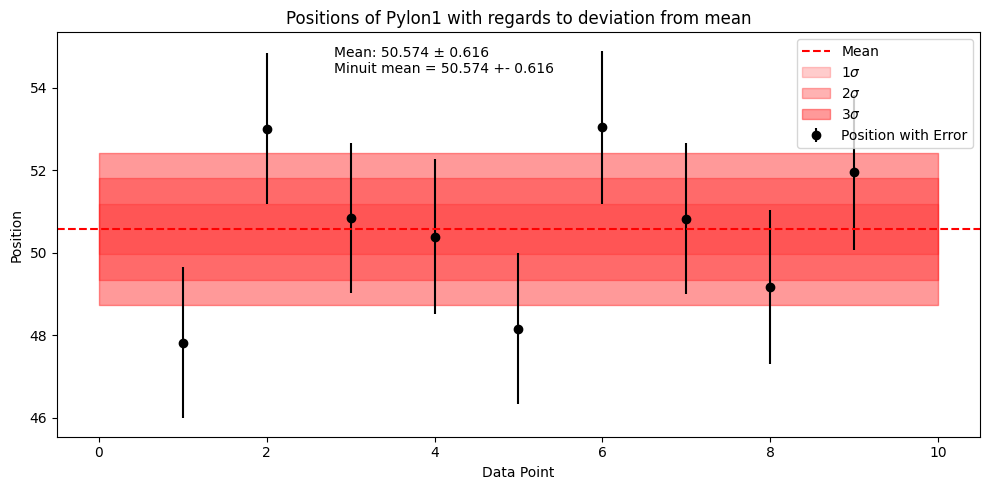

Pylon1 position after removing outliers: 50.57 ± 0.62


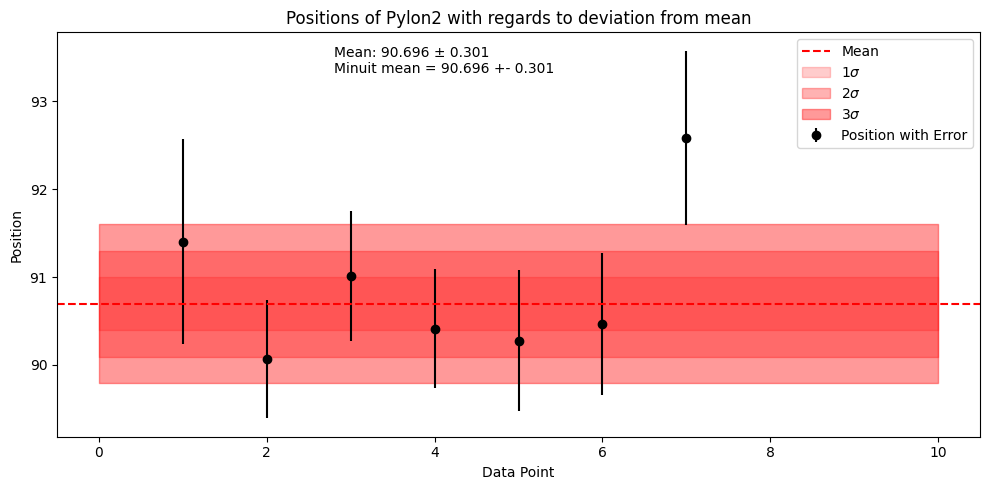

Pylon2 position after removing outliers: 90.70 ± 0.30


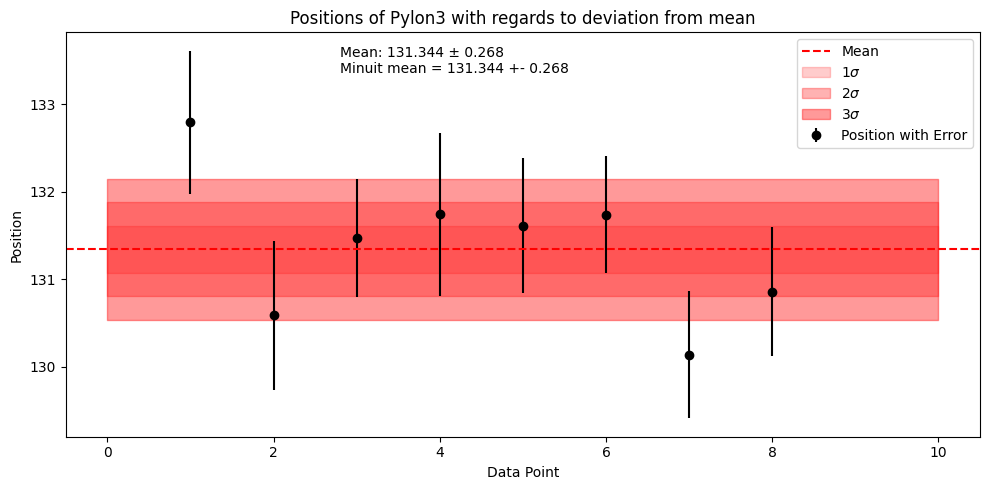

Pylon3 position after removing outliers: 131.34 ± 0.27


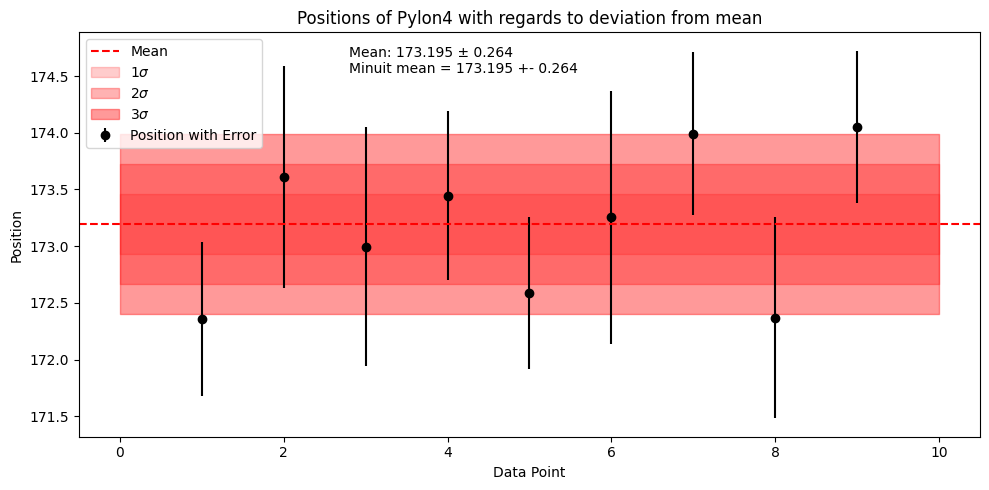

Pylon4 position after removing outliers: 173.19 ± 0.26


In [376]:
Pylon1_pos_w_error, Pylon1_pos_w_error_error =Errorbar(Pylon1_w_error, Pylon1_err, 'Pylon1')
Pylon2_pos_w_error, Pylon2_pos_w_error_error =Errorbar(Pylon2_w_error, Pylon2_err, 'Pylon2')
Pylon3_pos_w_error, Pylon3_pos_w_error_error =Errorbar(Pylon3_w_error, Pylon3_err, 'Pylon3')
Pylon4_pos_w_error, Pylon4_pos_w_error_error =Errorbar(Pylon4_w_error, Pylon4_err, 'Pylon4')


In [377]:
print(f'Pylon1 position without errors {Pylon1_pos_no_error:.2f} +- {Pylon1_pos_no_error_err:.2f} \nPylon1 position with errors {Pylon1_pos_w_error:.2f} +- {Pylon1_pos_w_error_error:.2f}')
print('')
print(f'Pylon2 position without errors {Pylon2_pos_no_error:.2f} +- {Pylon2_pos_no_error_err:.2f} \nPylon2 position with errors {Pylon2_pos_w_error:.2f} +- {Pylon2_pos_w_error_error:.2f}')
print('')
print(f'Pylon3 position without errors {Pylon3_pos_no_error:.2f} +- {Pylon3_pos_no_error_err:.2f} \nPylon3 position with errors {Pylon3_pos_w_error:.2f} +- {Pylon3_pos_w_error_error:.2f}')
print('')
print(f'Pylon4 position without errors {Pylon4_pos_no_error:.2f} +- {Pylon4_pos_no_error_err:.2f} \nPylon4 position with errors {Pylon4_pos_w_error:.2f} +- {Pylon4_pos_w_error_error:.2f}')

Pylon1 position without errors 50.75 +- 0.47 
Pylon1 position with errors 50.57 +- 0.62

Pylon2 position without errors 91.30 +- 0.12 
Pylon2 position with errors 90.70 +- 0.30

Pylon3 position without errors 131.47 +- 0.16 
Pylon3 position with errors 131.34 +- 0.27

Pylon4 position without errors 172.95 +- 0.14 
Pylon4 position with errors 173.19 +- 0.26


To check whether or not the values agree with one another, I will peform a two sided t-test to see if the means are the same. And if they are, I will combine them in a weighted average to get the final position of the pylon.

In [378]:
def test(mean1, mean2, unc1, unc2):
    return (mean1 - mean2)/np.sqrt(unc1**2 + unc2**2)

t = test(Pylon1_pos_no_error, Pylon1_pos_w_error, Pylon1_pos_no_error_err, Pylon1_pos_w_error_error)
p = stats.t.sf(abs(t), len(Pylon1_w_error) - 1)
print(f'Test for Pylon1: {t:.2f}, p = {p:.2f}')

t2 = test(Pylon2_pos_no_error, Pylon2_pos_w_error, Pylon2_pos_no_error_err, Pylon2_pos_w_error_error)
p2 = stats.t.sf(abs(t2), len(Pylon2_w_error) - 1)
print(f'Test for Pylon2: {t2:.2f}, p = {p2:.2f}')

t3 = test(Pylon3_pos_no_error, Pylon3_pos_w_error, Pylon3_pos_no_error_err, Pylon3_pos_w_error_error)
p3 = stats.t.sf(abs(t3), len(Pylon3_w_error) - 1)
print(f'Test for Pylon3: {t3:.2f}, p = {p3:.2f}')

t4 = test(Pylon4_pos_no_error, Pylon4_pos_w_error, Pylon4_pos_no_error_err, Pylon4_pos_w_error_error)
p4 = stats.t.sf(abs(t4), len(Pylon4_w_error) - 1)
print(f'Test for Pylon4: {t4:.2f}, p = {p4:.2f}')

#Combining the data
Pylon1_position, Pylon1_position_err = weighted([Pylon1_pos_no_error, Pylon1_pos_w_error], [Pylon1_pos_no_error_err, Pylon1_pos_w_error_error])
print(f'Pylon1 position: {Pylon1_position:.2f} ± {Pylon1_position_err:.2f}')

Pylon2_position, Pylon2_position_err = weighted([Pylon2_pos_no_error, Pylon2_pos_w_error], [Pylon2_pos_no_error_err, Pylon2_pos_w_error_error])
print(f'Pylon2 position: {Pylon2_position:.2f} ± {Pylon2_position_err:.2f}')

Pylon3_position, Pylon3_position_err = weighted([Pylon3_pos_no_error, Pylon3_pos_w_error], [Pylon3_pos_no_error_err, Pylon3_pos_w_error_error])
print(f'Pylon3 position: {Pylon3_position:.2f} ± {Pylon3_position_err:.2f}')

Pylon4_position, Pylon4_position_err = weighted([Pylon4_pos_no_error, Pylon4_pos_w_error], [Pylon4_pos_no_error_err, Pylon4_pos_w_error_error])
print(f'Pylon4 position: {Pylon4_position:.2f} ± {Pylon4_position_err:.2f}')

Test for Pylon1: 0.23, p = 0.41
Test for Pylon2: 1.84, p = 0.06
Test for Pylon3: 0.41, p = 0.35
Test for Pylon4: -0.82, p = 0.22
Pylon1 position: 50.69 ± 0.37
Pylon2 position: 91.21 ± 0.12
Pylon3 position: 131.44 ± 0.13
Pylon4 position: 173.00 ± 0.12


As all of my test yield a p-value above 0.05 I cannot reject that they come from the same distribution. Therefore I can say they do match.

In [379]:
Pylon_positions = np.array([Pylon1_position, Pylon2_position, Pylon3_position, Pylon4_position])
Pylon_positions_err = np.array([Pylon1_position_err, Pylon2_position_err, Pylon3_position_err, Pylon4_position_err])

def equidistant(x, x_err):
    distance = np.array([])
    d_err = np.array([])
    for i in range(len(x)-1):
        distance = np.append(distance, x[i+1] - x[i])
        d_err = np.append(d_err, np.sqrt(x_err[i]**2 + x_err[i+1]**2))

    return distance, d_err

distance, d_err = equidistant(Pylon_positions, Pylon_positions_err)
print(f'Distance between pylons: {distance} ± {d_err}')

Average_distance, Average_distance_err = weighted(distance, d_err)
print(f'Average distance between pylons: {Average_distance:.2f} ± {Average_distance_err:.2f}')

t1_2 = test(distance[0], Average_distance, d_err[0], Average_distance_err)
p1_2 = stats.t.sf(abs(t1_2), len(distance) - 1)
print(f'Test for distance between Pylon 1 & 2 agreeing with the average distance: {t1_2:.2f}, p = {p1_2:.2f}')

t2_3 = test(distance[1], Average_distance, d_err[1], Average_distance_err)
p2_3 = stats.t.sf(abs(t2_3), len(distance) - 1)
print(f'Test for distance between Pylon 2 & 3 agreeing with the average distance: {t2_3:.2f}, p = {p2_3:.2f}')

t3_4 = test(distance[2], Average_distance, d_err[2], Average_distance_err)
p3_4 = stats.t.sf(abs(t3_4), len(distance) - 1)
print(f'Test for distance between Pylon 3 & 4 agreeing with the average distance: {t3_4:.2f}, p = {p3_4:.2f}')



Distance between pylons: [40.51939184 40.23158347 41.56352332] ± [0.3890923  0.17684916 0.18285625]
Average distance between pylons: 40.84 ± 0.12
Test for distance between Pylon 1 & 2 agreeing with the average distance: -0.79, p = 0.26
Test for distance between Pylon 2 & 3 agreeing with the average distance: -2.85, p = 0.05
Test for distance between Pylon 3 & 4 agreeing with the average distance: 3.30, p = 0.04


To check if the pylons are equidistant, I perfomed a 1 sided t-test to see if the how much the differ from the mean, as if they were truly equidistant they should all be within a few sigma of the mean, with a p-value above 0.05. I see that for the last Pylons (3 to 4) they do not seem to agree with the mean, and therefore, from this data I can reject the Null hypothesis that they are equidistant.

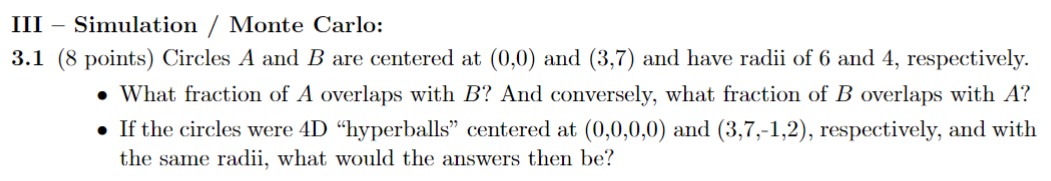

I will make a box around both circles with dimensions (13, 17), as that will precicely cover both boxes. Then I will run a monte carlo simulation and generate 1000 points for each simulation that a uniformely distributed in the box. I will then check if the point is within the circle and count the number of points that are within each circle and see what fraction of A is inside B and vice Versa. Same method can be used in 4 dimensions.

In [380]:
r = np.random
r.seed(42)

N_exp = 100
N_points = 1000

In [381]:
radius_A = 6
origin_A = np.array([0, 0, 0, 0])
radius_B = 4
origin_B = np.array([3, 7, -1, 2])

Overlap_A = np.zeros(N_exp)
Overlap_B = np.zeros(N_exp)

for i in range(N_exp):
    x = r.uniform(-6, 7, N_points)
    y = r.uniform(-6, 11, N_points)

    A_inside = (x - origin_A[0])**2 + (y - origin_A[1])**2 <= radius_A**2


    B_inside = (x - origin_B[0])**2 + (y - origin_B[1])**2 <= radius_B**2

    #Points in both A and B
    A_B = np.sum(A_inside & B_inside)

    Overlap_A[i] = A_B/np.sum(A_inside)
    Overlap_B[i] = A_B/np.sum(B_inside)

    if (i < 2):
        print(f'Overlap of A: {Overlap_A[i]:.2f} \nOverlap of B: {Overlap_B[i]:.2f}')
    
Mean_overlap_A = np.mean(Overlap_A)
Mean_overlap_B = np.mean(Overlap_B)

print(f'In 2D:\nMean overlap of A: {Mean_overlap_A:.2f} \nMean overlap of B: {Mean_overlap_B:.2f}')

for i in range(N_exp):
    x = r.uniform(-6, 7, N_points)
    y = r.uniform(-6, 11, N_points)
    z = r.uniform(-6,6, N_points)
    k = r.uniform(-6,6, N_points)


    A_inside = (x - origin_A[0])**2 + (y - origin_A[1])**2 + (z - origin_A[2])**2 + (k - origin_A[3])**2 <= radius_A**2
    
    B_inside = (x - origin_B[0])**2 + (y - origin_B[1])**2 + (z - origin_B[2])**2 + (k - origin_B[3])**2 <= radius_B**2



    #Points in both A and B
    A_B = np.sum(A_inside & B_inside)

    Overlap_A[i] = A_B/np.sum(A_inside)
    Overlap_B[i] = A_B/np.sum(B_inside)

    if (i < 2):
        print(f'In 4D: \nOverlap of A: {Overlap_A[i]:.2f} \nOverlap of B: {Overlap_B[i]:.2f}')


Overlap of A: 0.10 
Overlap of B: 0.21
Overlap of A: 0.08 
Overlap of B: 0.19
In 2D:
Mean overlap of A: 0.09 
Mean overlap of B: 0.20
In 4D: 
Overlap of A: 0.01 
Overlap of B: 0.08
In 4D: 
Overlap of A: 0.00 
Overlap of B: 0.00


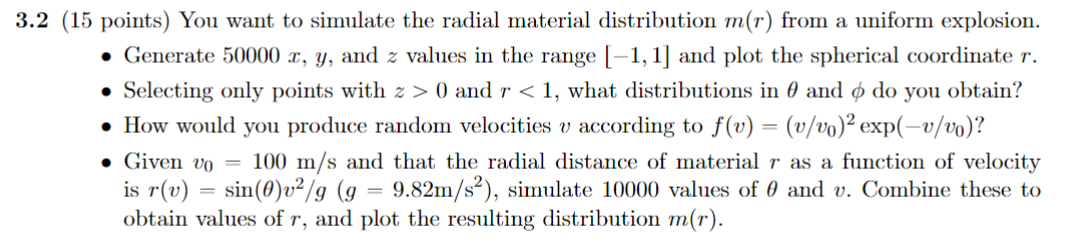

I will here use Monte-Carlo simulations to simulate the radial maetrial distribution. Letting $r = \sqrt(x^2 +y^2 +z^2)$. I assume that it is uniform distributed within a cube of 2x2x2.

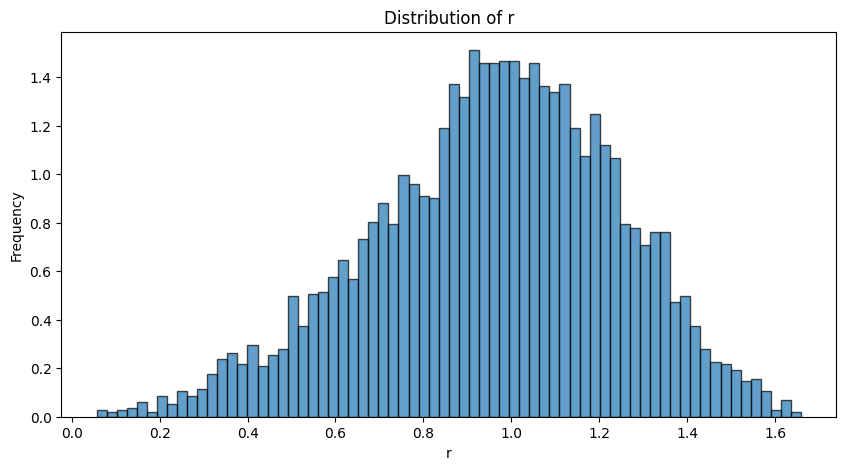

In [382]:
N_exp = 5000


r_vec = np.array([])
for i in range(N_exp):
    x = r.uniform(-1,1)
    y = r.uniform(-1,1)
    z = r.uniform(-1,1)

    r_vec = np.append(r_vec, np.sqrt(x**2 + y**2 + z**2))

plt.figure(figsize=(10, 5))
plt.hist(r_vec, bins=int(np.sqrt(N_exp)), edgecolor='black', density = True, alpha=0.7, label='Distribution of r')
plt.xlabel('r')
plt.ylabel('Frequency')
plt.title('Distribution of r')
plt.show()


This shows the density of points at different radial distances.

Here I use that 
$ r = \sqrt(x^2 +y^2 +z^2) $ and $ \theta = \arccos(\frac{z}{r}) $ and $ \phi = \arctan2(y,x) $ to convert the cartesian coordinates to spherical coordinates.

Chi2/ndf for uniform distribution: 1.34 p = 0.09
Chi2/ndf for sinusoidal distribution: 1.06 p = 0.37


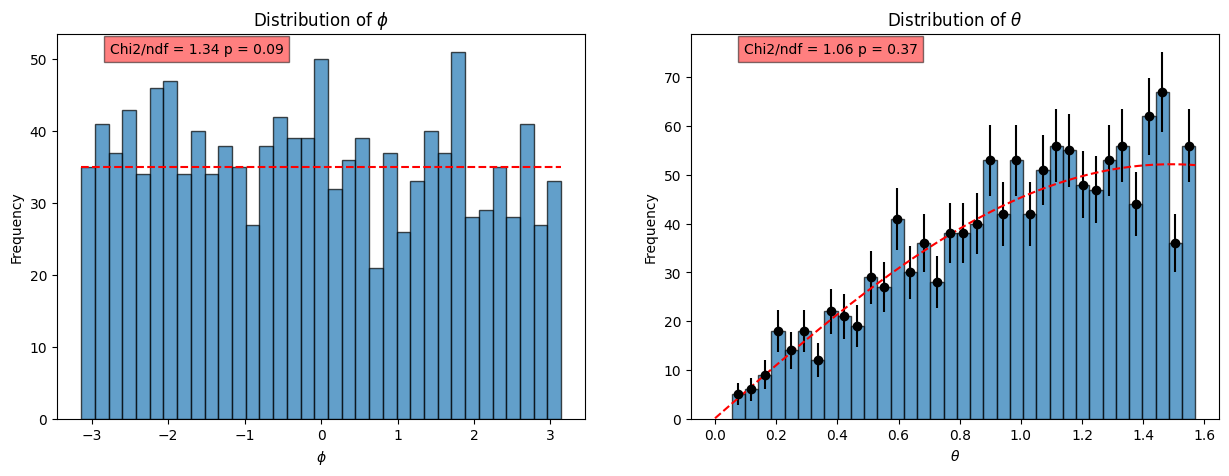

In [383]:
r = np.random
r.seed(42)

N_exp = 5000

r_vec = np.array([])
phi = np.array([])
theta = np.array([])
for i in range(N_exp):
    x = r.uniform(-1,1)
    y = r.uniform(-1,1)
    z = r.uniform(-1,1)
    r_vec_d = np.sqrt(x**2 + y**2 + z**2)

    if z > 0 and r_vec_d < 1:
        phi = np.append(phi, np.arctan2(y,x))
        theta = np.append(theta, np.arccos(z/r_vec_d))
        r_vec = np.append(r_vec, r_vec_d)

# def likelihood_uniform(center, width):
#     if center < 0 or center + width > np.pi or width <= 0: #Check if the center and width is within the range of the distribution
#         return 0
#     else:
#         k = 1/width
#         return np.sum(-np.log(k))
    
def sinusoidal(x, A, omega, phi_0):
    return A*np.sin(omega*x + phi_0)

def uniform(x, mean):
    # k = (2*np.pi)/int(np.sqrt(len(x)))
    # N_norm = k*len(x)
    return np.ones_like(x)*mean
    
# def get_chi2_ndf(hist, const):
#     data = hist[0]
#     const_unnormed = const * data.sum()
#     chi2 = np.sum( (data - const_unnormed)**2 / data )
#     ndof = data.size
#     return chi2, ndof


#chi2 Uniform
counts1, edges1 = np.histogram(phi, bins=int(np.sqrt(len(phi))))
x_chi2_uni = (edges1[1:] + edges1[:-1])/2
x_chi2_uni = x_chi2_uni[counts1 > 0]
y_chi2_uni = counts1[counts1 > 0]
yerr_chi2 = np.sqrt(y_chi2_uni)


fit_uni = cost.LeastSquares(x_chi2_uni, y_chi2_uni, yerr_chi2, uniform)
m_uni = Minuit(fit_uni, mean = 1/(2*np.pi))
m_uni.migrad()
chi2_uniform = m_uni.fval
ndf_chi = len(x_chi2_uni) - 1
p_chi = stats.chi2.sf(chi2_uniform, ndf_chi)
print(f'Chi2/ndf for uniform distribution: {chi2_uniform/ndf_chi:.2f} p = {p_chi:.2f}')
x_uniform = np.linspace(-np.pi, np.pi, 1000)
y_uniform = uniform(x_uniform, m_uni.values['mean'])


#chi2 Sinusoidal
counts, edges = np.histogram(theta, bins=int(np.sqrt(len(theta))))
x_chi2 = (edges[1:] + edges[:-1])/2
x_chi2 = x_chi2[counts > 0]
y_chi2 = counts[counts > 0]
yerr_chi2 = np.sqrt(y_chi2)

A_guess = 1
omega_guess = 1
phi_0_guess = 0

#sinusoidal                    
fit = cost.LeastSquares(x_chi2, y_chi2, yerr_chi2, sinusoidal)
m_chi2 = Minuit(fit, A = A_guess, omega = omega_guess, phi_0 = phi_0_guess)
m_chi2.migrad()
chi2_sigmoid = m_chi2.fval
ndf = len(x_chi2) - 3
p = stats.chi2.sf(chi2_sigmoid, ndf)
print(f'Chi2/ndf for sinusoidal distribution: {chi2_sigmoid/ndf:.2f} p = {p:.2f}')

x_sigmoid_chi2 = np.linspace(0, np.pi/2, 1000)
# y_sigmoid_chi2 = sigmoid(x_sigmoid, m_sigmoid.values['L'], m_sigmoid.values['k'], m_sigmoid.values['x_0'])
y_sigmoid_chi2 = sinusoidal(x_sigmoid_chi2, m_chi2.values['A'], m_chi2.values['omega'], m_chi2.values['phi_0'])


fig,ax = plt.subplots(1,2,figsize=(15, 5))
ax[0].hist(phi, bins=int(np.sqrt(len(phi))), edgecolor='black', density = False, alpha=0.7, label='Distribution of $\phi$')
ax[0].plot(x_uniform, y_uniform, color='red', linestyle='--', label='Uniform distribution')
ax[0].text(0.1, 0.95, f'Chi2/ndf = {chi2_uniform/ndf_chi:.2f} p = {p_chi:.2f}', transform=ax[0].transAxes,
           bbox=dict(facecolor='red', alpha=0.5))
ax[0].set_xlabel('$\phi$')
ax[0].set_ylabel('Frequency')
ax[0].set_title(r'Distribution of $\phi$')


ax[1].hist(theta, bins=int(np.sqrt(len(theta))), edgecolor='black', density = False, alpha=0.7, label='Distribution of $\theta$')
ax[1].errorbar(x_chi2, y_chi2, yerr=yerr_chi2, fmt='o', color='black', label='Distribution of $\theta$')
ax[1].plot(x_sigmoid_chi2, y_sigmoid_chi2, color='red', linestyle='--', label='Sigmoid distribution from chi2')
ax[1].text(0.1, 0.95, f'Chi2/ndf = {chi2_sigmoid/ndf:.2f} p = {p:.2f}', transform=ax[1].transAxes,
           bbox=dict(facecolor='red', alpha=0.5))
ax[1].set_xlabel(r'$\theta$')
ax[1].set_ylabel('Frequency')
ax[1].set_title(r'Distribution of $\theta$')
plt.show()



The distribution of $\phi$ is uniform, as expected as it is calculated from x and y and both are uniform. The distribution of $\theta$ is not uniform, as it is calculated from z and r, and r is not uniform and seems to follow a sinusoidal, futhermore it's limited to the range of $[0, \pi/2]$, since it's only z > 0.

Both of these are distributions have given a reasonable p-value and therefore I can say that they are uniform and sinusoidal respectively.

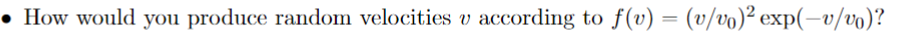

Since I can assume that $v_0$ is a constant and let $x = \frac{v}{v_0}$ I can rewrite the equation:

$f(x) = x^2e^{-x}$

I can then find the CDF by integrating the function from 0 to x and inverting it, to use the transformation method to generate random velocites from the given PDF.

$ F(x) = \int_0^x f(x) dx $

Solved using maple I get:

$ F(x) = 2 + (-x^2 - 2x - 2)e^{-x}$

Looks like it's not possible to use the transformation method to generate random velocities from the given PDF, as the inverse of the CDF is not possible to solve for, I will therefore use the accept/reject method instead. And from plotting I see the function approaches 0 at x=10, so I will use that as my range. And use the range for y from 0 to 1, as I can clearly see 1 is way above the maxium of the function! I will use 1000 points to try the accept/reject method.

Text(0.5, 1.0, 'Velocity')

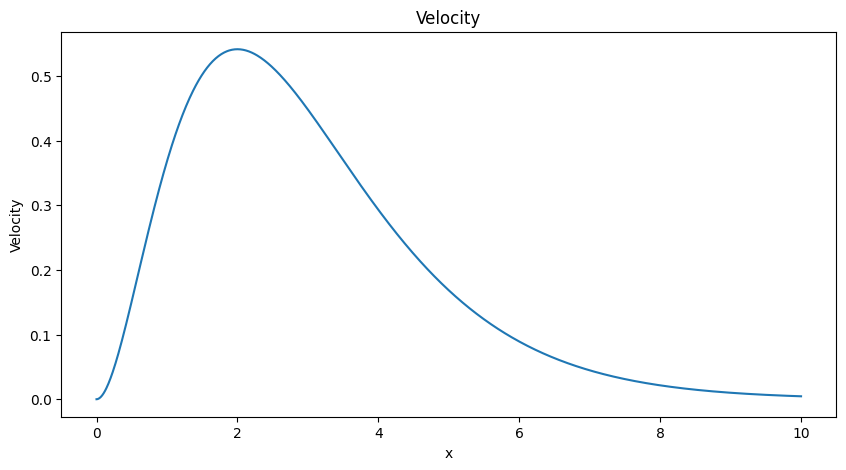

In [384]:
def velocities(x):
    return x**2*np.exp(-x)

x = np.linspace(0, 10, 1000)
y = velocities(x)

plt.figure(figsize=(10, 5))
plt.plot(x, y, label='Velocity')
plt.xlabel('x')
plt.ylabel('Velocity')
plt.title('Velocity')

Integral: 1.95 ± 0.06
Efficiency: 19.48% ± 0.55%


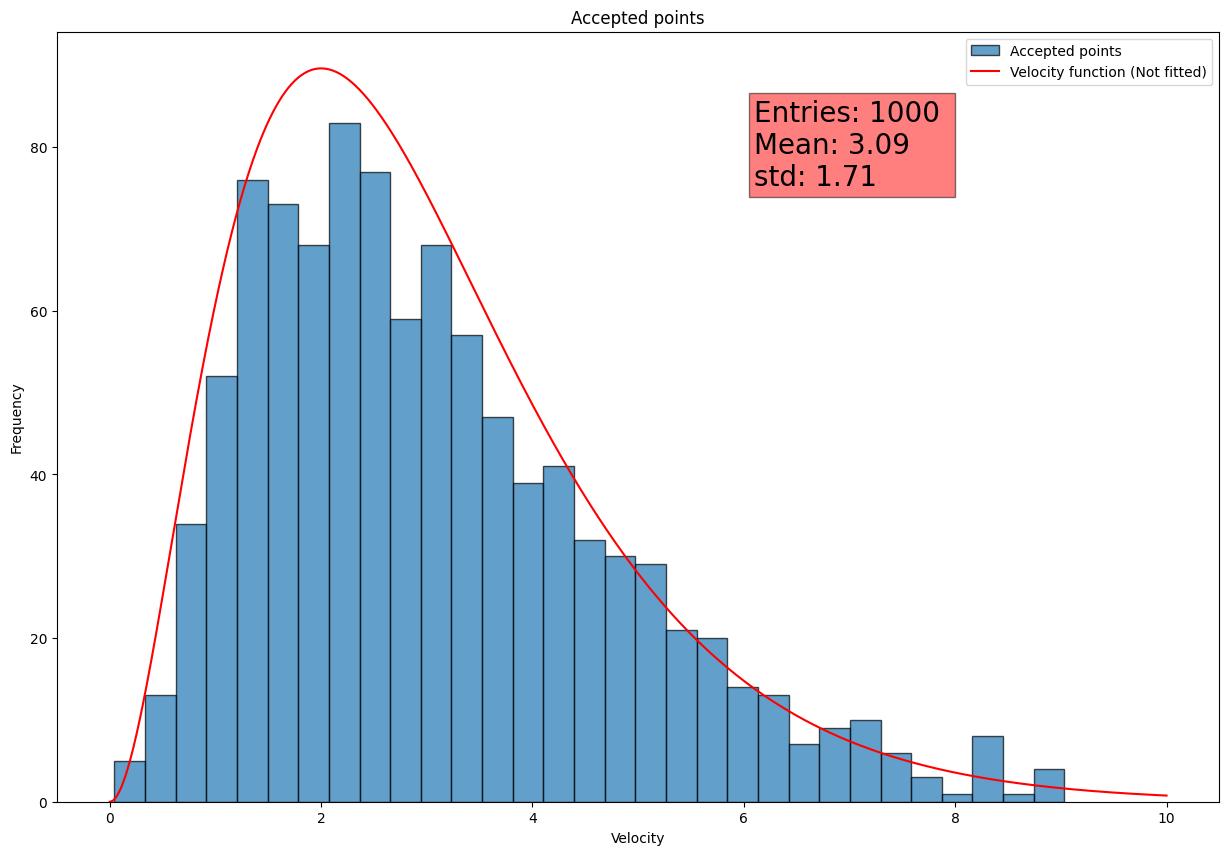

In [385]:



xmin, xmax = 0, 10
ymin, ymax = 0, 1
N_points = 1000
Nbins = int(np.sqrt(N_points))


x_accepted = np.zeros(N_points)
Ntry = 0
for i in range(N_points):
    while True:
        Ntry += 1
        x = r.uniform(xmin, xmax)
        y = r.uniform(ymin, ymax)
        if (y < x**2*np.exp(-x)):
            break
    x_accepted[i] = x

eff = N_points / Ntry                        # Efficiency of generating points (fraction accepted)
eff_error = np.sqrt(eff * (1-eff) / Ntry)    # Error on efficiency (binomial)
integral =  eff * (xmax-xmin) * ymax               # Integral
integral_error = eff_error * (xmax-xmin) * ymax    # Error on integral

print(f'Integral: {integral:.2f} ± {integral_error:.2f}')
print(f'Efficiency: {eff:.2%} ± {eff_error:.2%}')

def velocities(x):
    k = (xmax-xmin)/Nbins
    N_norm = k*N_points
    return N_norm*1/integral*x**2*np.exp(-x)

x_plot = np.linspace(xmin, xmax, 1000)
y_plot = velocities(x_plot)

mean_x = np.mean(x_accepted)
std_x = np.std(x_accepted)

plt.figure(figsize=(15, 10))
plt.hist(x_accepted, bins=Nbins, edgecolor='black', density=False, alpha=0.7, label='Accepted points')
plt.plot(x_plot, y_plot, color='red', label='Velocity function (Not fitted)')
plt.text(0.6, 0.8, f'Entries: {N_points} \nMean: {mean_x:.2f} \nstd: {std_x:.2f}', transform=plt.gca().transAxes,
           bbox=dict(facecolor='red', alpha=0.5), fontsize=20)
plt.xlabel('Velocity')
plt.ylabel('Frequency')
plt.title('Accepted points')
plt.legend()
plt.show()




Max value : 52.18023995868088 and min value: -52.1795730030013


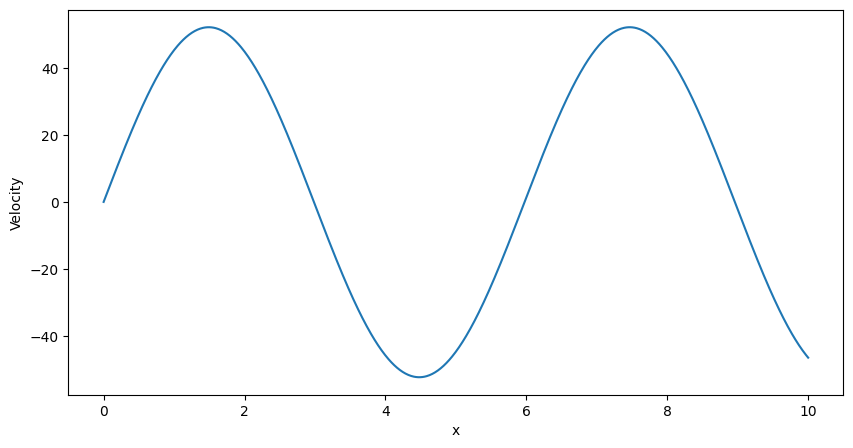

In [386]:
sinus_A = m_chi2.values['A']
sinus_Omega = m_chi2.values['omega']
sinus_phi_0 = m_chi2.values['phi_0']

x_lin = np.linspace(0, 10, 1000)
y_lin = sinusoidal(x_lin, sinus_A, sinus_Omega, sinus_phi_0)

plt.figure(figsize=(10, 5))
plt.plot(x_lin, y_lin, label='Velocity function')
plt.xlabel('x')
plt.ylabel('Velocity')

print(f'Max value : {np.max(y_lin)} and min value: {np.min(y_lin)}')


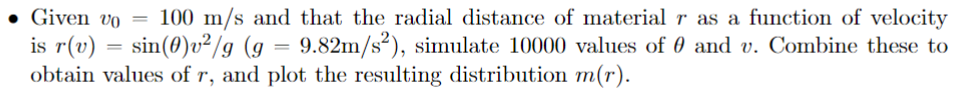

Chi2/ndf for exponential decay: 4.42 p = 0.00


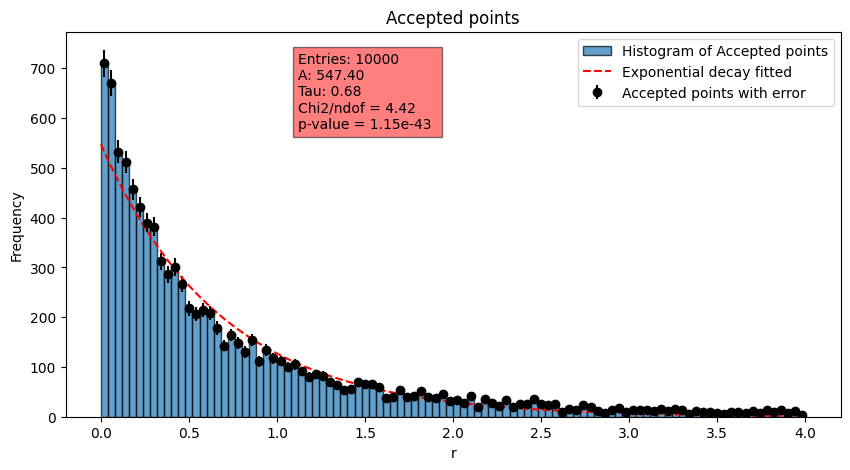

In [387]:
v_0 = 100 
g = 9.82
xmin, xmax = 0, 10
ymin, ymax = 0, 1

xmin_sinus, xmax_sinus = 0, np.pi/2
ymin_sinus, ymax_sinus = -53, 53

N_points = 10000
Nbins = int(np.sqrt(N_points))

sinus_A = m_chi2.values['A']
sinus_Omega = m_chi2.values['omega']
sinus_phi_0 = m_chi2.values['phi_0']

def sinusoidal(x, A, omega, phi_0):
    return A*np.sin(omega*x + phi_0)

v_accepted = np.zeros(N_points)
theta_accepted = np.zeros(N_points)
Ntry = 0
for i in range(N_points):
    while True:
        Ntry += 1
        x = r.uniform(xmin, xmax)
        y = r.uniform(ymin, ymax)
        if (y < x**2*np.exp(-x)):
            break
    v_accepted[i] = x

for i in range(N_points):
    while True:
        Ntry += 1
        x = r.uniform(xmin_sinus, xmax_sinus)
        y = r.uniform(ymin_sinus, ymax_sinus)
        if (y < sinusoidal(x, sinus_A, sinus_Omega, sinus_phi_0)):
            break
    theta_accepted[i] = x

def decay_exp(x,A, tau):
    return A*np.exp(-x/tau)

r_v = (np.sin(theta_accepted)*v_accepted**2)/g

counts, edges = np.histogram(r_v, bins=Nbins, range=(0,4))
x = (edges[1:] + edges[:-1])/2
x = x[counts > 0]
y = counts[counts > 0]
yerr = np.sqrt(y)

A_guess = 700
tau_guess = 0.1

fit = cost.LeastSquares(x, y, yerr, decay_exp)
m = Minuit(fit, A = A_guess, tau = tau_guess)
m.migrad()
chi2 = m.fval
ndf = len(x) - 2
p = stats.chi2.sf(chi2, ndf)
print(f'Chi2/ndf for exponential decay: {chi2/ndf:.2f} p = {p:.2f}')

x_exp = np.linspace(0, 4, 1000)
y_exp = decay_exp(x_exp,m.values['A'] ,m.values['tau'])

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(r_v, bins=Nbins, edgecolor='black', density=False, alpha=0.7, range = (0,4), label='Histogram of Accepted points')
ax.errorbar(x, y, yerr=yerr, fmt='o', color='black', label='Accepted points with error')
ax.plot(x_exp, y_exp, color='red', linestyle='--', label='Exponential decay fitted')
ax.text(0.3, 0.75, f'Entries: {N_points} \nA: {m.values["A"]:.2f} \nTau: {m.values["tau"]:.2f} \nChi2/ndof = {chi2/ndf:.2f} \np-value = {p:.2e} ', transform=ax.transAxes,
              bbox=dict(facecolor='red', alpha=0.5))
ax.set_xlabel('r')
ax.set_ylabel('Frequency')
ax.set_title('Accepted points')
ax.legend()
plt.show()

# ullhfit = cost.UnbinnedNLL(x, decay_exp)
# mfit_ullh = Minuit(ullhfit, A = A_guess, tau = tau_guess)
# #minuit_ullh.limits["Nexp", "Ngauss"] = (0,1)
# mfit_ullh.migrad()           # Perform the actual fit


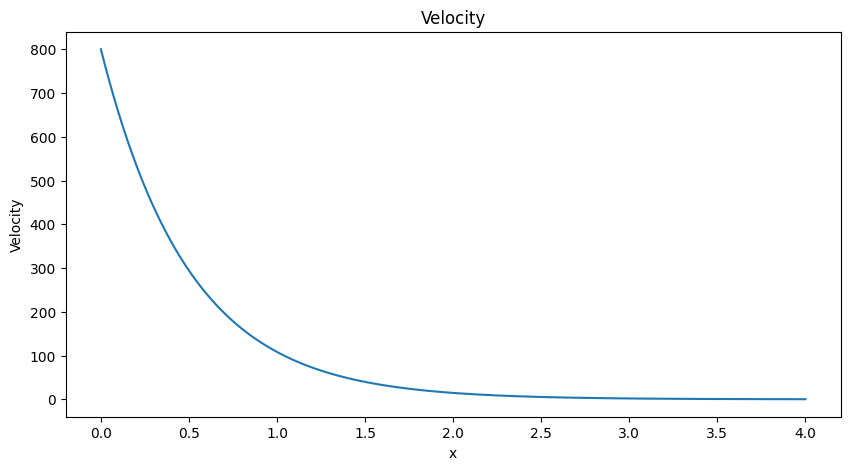

In [388]:
def decay_exp(x, A, tau):
    return A*np.exp(-x/tau)

A_guess = 800
tau_guess = 0.5
x_exp = np.linspace(0, 4, 1000)
y_exp = decay_exp(x_exp, A_guess, tau_guess)

plt.figure(figsize=(10, 5))
plt.plot(x_exp, y_exp, label='Exponential decay')
plt.xlabel('x')
plt.ylabel('Velocity')
plt.title('Velocity')
plt.show()


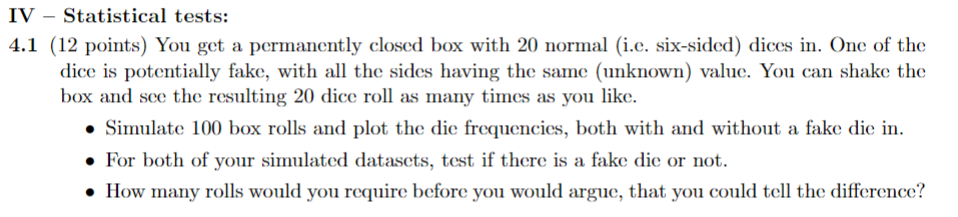

Fake value: 4
Frequencies of dice rolls: {1: 310.0, 2: 323.0, 3: 330.0, 4: 344.0, 5: 347.0, 6: 346.0}
Frequencies of dice rolls with fake dice: {1: 352.0, 2: 305.0, 3: 297.0, 4: 423.0, 5: 322.0, 6: 301.0}


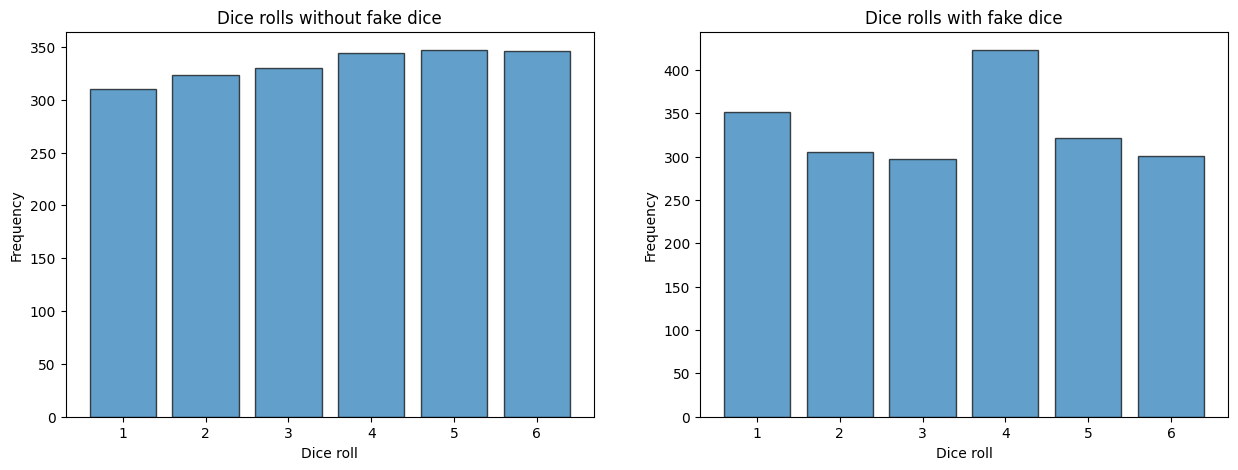

In [389]:
n_dice = 20
n_rolls = 100 


r = np.random
r.seed(42)
dice_rolls = np.array([])
dice_rolls_fake = np.array([])
fake_value = r.randint(1, 7)
print(f'Fake value: {fake_value}')
for i in range(n_rolls):
    dice_rolls = np.append(dice_rolls, r.randint(1, 7, n_dice))

    #fake_value = r.randint(1, 7)
    dice_rolls_fake = np.append(dice_rolls_fake, r.randint(1, 7, n_dice-1))
    dice_rolls_fake = np.append(dice_rolls_fake, fake_value)

def frequencies_func(rolls):
    freq = np.array([])
    for i in range(1, 7):
        freq = np.append(freq, np.sum(rolls == i))
    freq = {DiceNumber: freq for DiceNumber, freq in zip(range(1, 7), freq)}
    return freq

freq = frequencies_func(dice_rolls)
freq_fake = frequencies_func(dice_rolls_fake)

print(f'Frequencies of dice rolls: {freq}')
print(f'Frequencies of dice rolls with fake dice: {freq_fake}')

fig, ax = plt.subplots(1,2, figsize=(15, 5))
# ax[0].hist(dice_rolls, bins=int(np.sqrt(len(dice_rolls))), edgecolor='black', density=False, alpha=0.7, label='Dice rolls')
ax[0].bar(freq.keys(), freq.values(), edgecolor='black', alpha=0.7, label='Dice rolls')
ax[0].set_xlabel('Dice roll')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Dice rolls without fake dice')

# ax[1].hist(dice_rolls_fake, bins=int(np.sqrt(len(dice_rolls_fake))), edgecolor='black', density=False, alpha=0.7, label='Dice rolls')
ax[1].bar(freq_fake.keys(), freq_fake.values(), edgecolor='black', alpha=0.7, label='Dice rolls')
ax[1].set_xlabel('Dice roll')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Dice rolls with fake dice')
plt.show()




To test this I will use a chi2-squared test to see whether the dice rolls are consistent with being uniform, as they should if the dice is fair. I will use a significance level of 0.05. Since the chi2-squared test, test for the whole distribution compared to an expected distribution it didn't tell exactly which dice was the outlier. Therefore I also used a binomial test to test each dice number individually to see if they matched the expected distribution. I used a significance level of 0.05 for this test as well.

In [390]:
frequencies = list(freq.values())
frequencies_fake = list(freq_fake.values())

def fake_test(frequencies, n_rolls, n_dice = 20):
    total_obs = n_dice*n_rolls
    expected = total_obs/6

    expected = np.full(6, expected)
    # frequencies = np.array(frequencies)*(total_obs/expected)

    chi2, p_value = stats.chisquare(frequencies, expected)

    return chi2, p_value

def fake_test2(frequencies, n_rolls = 100, n_dice = 20):
    total_obs = n_dice*n_rolls
    expected = 1/6
    p_value = np.array([])
    for i in range(len(frequencies)):
        p_value = np.append(p_value, stats.binomtest(int(frequencies[i]), n=total_obs, p=expected))
    return p_value



chi2, p_value = fake_test(frequencies, n_rolls = 100) 
chi2_fake, p_value_fake = fake_test(frequencies_fake, n_rolls = 100)

p_value_binom = fake_test2(frequencies)
p_value_fake_binom = fake_test2(frequencies_fake)
# print(p_value_binom[0].pvalue)
# print(f'p_value for dice rolls: {p_value_binom}')
for i in range(len(p_value_binom)):
    print(f'p_value for dice {i+1}: {p_value_binom[i].pvalue:.2f}')

for i in range(len(p_value_fake_binom)):
    print(f'p_value for fake dice {i+1}: {p_value_fake_binom[i].pvalue:.2f}')


print(f'Chi2 for dice rolls: {chi2:.2f} p = {p_value:.2f}')
print(f'Chi2 for dice rolls with fake dice: {chi2_fake:.2f} p = {p_value_fake:.2f}')





p_value for dice 1: 0.17
p_value for dice 2: 0.55
p_value for dice 3: 0.86
p_value for dice 4: 0.53
p_value for dice 5: 0.42
p_value for dice 6: 0.45
p_value for fake dice 1: 0.27
p_value for fake dice 2: 0.09
p_value for fake dice 3: 0.03
p_value for fake dice 4: 0.00
p_value for fake dice 5: 0.51
p_value for fake dice 6: 0.05
Chi2 for dice rolls: 3.37 p = 0.64
Chi2 for dice rolls with fake dice: 35.06 p = 0.00


I perform a simulation that will run over a number of rolls, starting from 100 and increasing by a stepsize of 1. For each number of rolls, I will calculate a p-value using the chi2-squared test and see when the p-value is below 0.05 for the one with the fake dice. I will then use the number of rolls that gave a p-value below 0.05 as the number of rolls needed to reject the null hypothesis that the dice is fair. Furthermore I will plot the first few histograms, to ensure that I visueally can tell the difference. I also plot the p-value as a function of the number of rolls.

[0.00704092]
[0.08953597 0.67133355 0.16161454 0.00338625 0.49716696 0.03750996]
Null hypothesis rejected for dice rolls with 50 rolls
[0.00704092 0.22589857]
[0.29563215 0.0271886  0.33287583 0.43855345 0.7863401  0.56130498]
[0.00704092 0.22589857 0.00107613]
[0.00228214 0.4734341  0.01788523 0.08512533 0.04453978 0.31546213]
Null hypothesis rejected for dice rolls with 70 rolls
[0.00704092 0.22589857 0.00107613 0.0096901 ]
[0.28303301 0.09343685 0.0291721  0.00975759 0.66286089 0.14928751]
Null hypothesis rejected for dice rolls with 80 rolls
[7.04092254e-03 2.25898573e-01 1.07612615e-03 9.69010486e-03
 4.53199546e-06]
[6.61653300e-07 9.24428354e-01 3.14891019e-02 1.06697155e-01
 3.42770272e-01 3.14891019e-02]
Null hypothesis rejected for dice rolls with 90 rolls
[7.04092254e-03 2.25898573e-01 1.07612615e-03 9.69010486e-03
 4.53199546e-06 3.63489378e-06]
[1.99812267e-07 5.68635146e-01 4.12780879e-02 3.31823093e-02
 5.09358792e-01 2.80181126e-01]
Null hypothesis rejected for dice rol

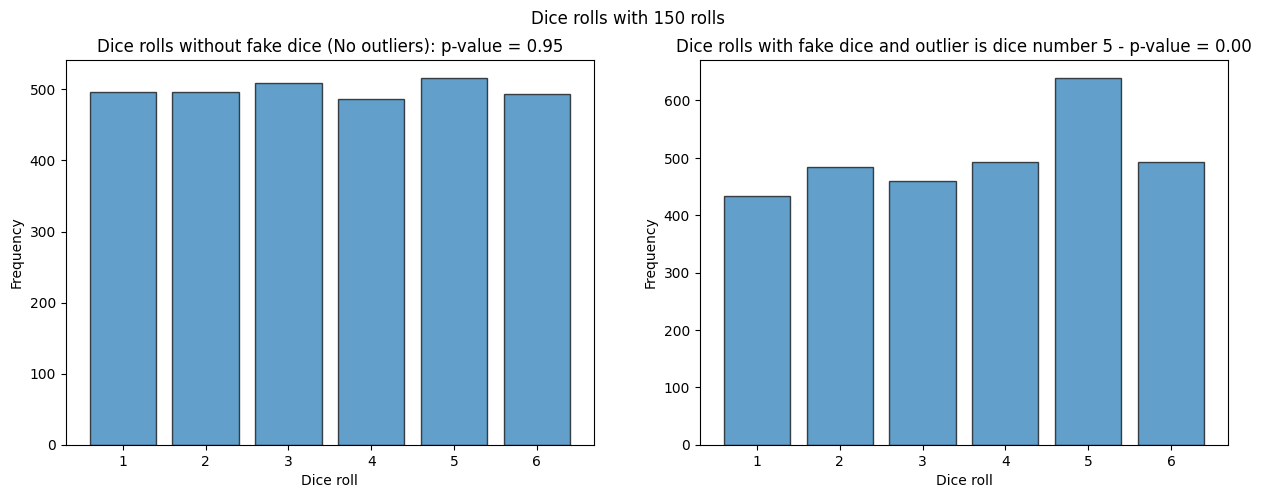

[7.04092254e-03 2.25898573e-01 1.07612615e-03 9.69010486e-03
 4.53199546e-06 3.63489378e-06 2.03708120e-07 3.43295653e-05
 1.79632845e-05 1.10745970e-09 6.88289391e-10 4.40156847e-08]
[3.19228922e-01 2.08720757e-08 3.09674582e-04 3.07766379e-01
 1.06757355e-01 5.69280105e-01]
Null hypothesis rejected for dice rolls with 160 rolls
[7.04092254e-03 2.25898573e-01 1.07612615e-03 9.69010486e-03
 4.53199546e-06 3.63489378e-06 2.03708120e-07 3.43295653e-05
 1.79632845e-05 1.10745970e-09 6.88289391e-10 4.40156847e-08
 2.34523986e-07]
[7.59640695e-03 5.04642349e-01 1.60489416e-01 2.69359544e-01
 1.89739046e-01 1.11493865e-08]
Null hypothesis rejected for dice rolls with 170 rolls
[7.04092254e-03 2.25898573e-01 1.07612615e-03 9.69010486e-03
 4.53199546e-06 3.63489378e-06 2.03708120e-07 3.43295653e-05
 1.79632845e-05 1.10745970e-09 6.88289391e-10 4.40156847e-08
 2.34523986e-07 8.04726400e-08]
[2.54092748e-01 4.88200469e-01 1.02560509e-01 1.58871858e-01
 4.85417610e-10 1.58871858e-01]
Null hypothe

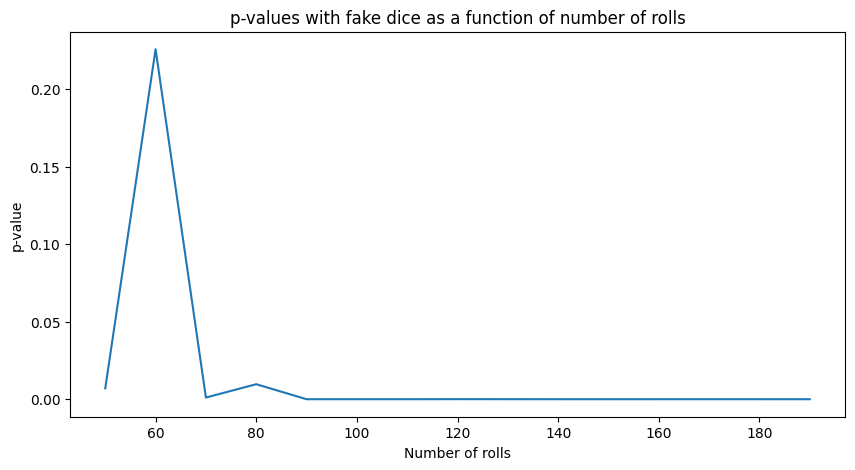

In [391]:
r = np.random
r.seed(42)

def difference_check(start, max_rolls, step_size, n_dice = 20):
    p_values = np.array([])
    p_values_fake = np.array([])
    i = 0   
    for n_rolls in range(start, max_rolls, step_size):
        Null_rejected = 0
        dice_rolls = np.array([])
        dice_rolls_fake = np.array([])

        fake_value = r.randint(1, 7)
        for i in range(n_rolls):
            dice_rolls = np.append(dice_rolls, r.randint(1, 7, n_dice))

            dice_rolls_fake = np.append(dice_rolls_fake, r.randint(1, 7, n_dice-1))
            dice_rolls_fake = np.append(dice_rolls_fake, fake_value)
        freq = frequencies_func(dice_rolls)
        freq_fake = frequencies_func(dice_rolls_fake) 
    
 
        chi2, p_value_chi2 = fake_test(list(freq.values()), n_rolls)
        chi2_fake, p_value_fake_chi = fake_test(list(freq_fake.values()), n_rolls)

        p_value = fake_test2(list(freq.values()), n_rolls)
        p_value_fake = fake_test2(list(freq_fake.values()), n_rolls)
        p_value_list = np.array([])
        p_value_fake_list = np.array([])
  
        for i in range(6):
            p_value_fake_list = np.append(p_value_fake_list, p_value_fake[i].pvalue)
            p_value_list = np.append(p_value_list, p_value[i].pvalue)
        
        # print(p_value_fake)
        # p_values = np.append(p_values, p_value)
        p_values_fake = np.append(p_values_fake, p_value_fake_chi)
        print(p_values_fake)
        print(p_value_fake_list)
        p_values_fake_chi_min = p_values_fake.min()
        # print(f'p_value for dice rolls: {p_values_fake_chi_min:.2f}')
    

        p_values_min = p_value_list[np.argmin(p_value_fake_list)]
        p_values_fake_min = p_value_fake_list.min()
       

        if p_values_fake[-1] < 0.05:
            i += 1
            Null_rejected += 1
            print(f'Null hypothesis rejected for dice rolls with {n_rolls} rolls')
            if n_rolls == max_rolls - 5*step_size:
                fig, ax = plt.subplots(1,2, figsize=(15, 5))
                ax[0].bar(freq.keys(), freq.values(), edgecolor='black', alpha=0.7, label='Dice rolls')
                ax[0].set_xlabel('Dice roll')
                ax[0].set_ylabel('Frequency')
                ax[0].set_title(f'Dice rolls without fake dice (No outliers): p-value = {p_value_chi2:.2f}')
                
                ax[1].bar(freq_fake.keys(), freq_fake.values(), edgecolor='black', alpha=0.7, label='Dice rolls')
                ax[1].set_xlabel('Dice roll')
                ax[1].set_ylabel('Frequency')
                ax[1].set_title(f'Dice rolls with fake dice and outlier is dice number {np.argmin(p_value_fake_list) +1} - p-value = {p_values_fake_min:.2f}')

                fig.suptitle(f'Dice rolls with {n_rolls} rolls')
                plt.show()
    return p_values_fake

max_rolls = 200
step_size = 10
start = 50

p_values = difference_check(start,max_rolls, step_size)
print(p_values.shape)

x = np.arange(start, max_rolls, step_size)
print(x.shape)
plt.figure(figsize=(10, 5))
plt.plot(x, p_values, label='p-values')
plt.xlabel('Number of rolls')
plt.ylabel('p-value')
plt.title('p-values with fake dice as a function of number of rolls')
plt.show()

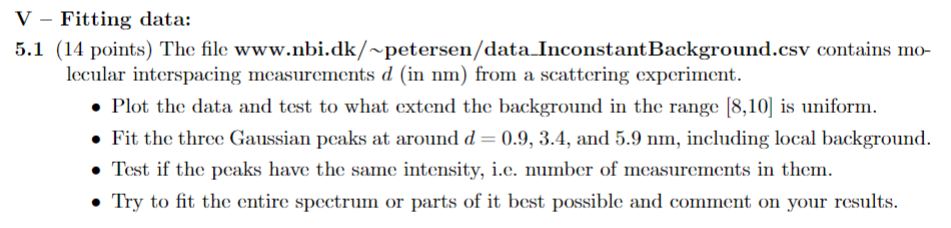

I will quickly plot the data, assuming poission errors on the counts of my bins. And then I will fit a line to the data, using a least square fit in the range [8,10] to check if the data is uniform.

21933
0        0.731347
1        0.563616
2        0.976521
3       -0.976048
4       -0.464304
           ...   
21928    1.462794
21929   -0.261074
21930   -1.078692
21931    0.809237
21932   -0.384982
Name: # Distance, Length: 21933, dtype: float64
21933


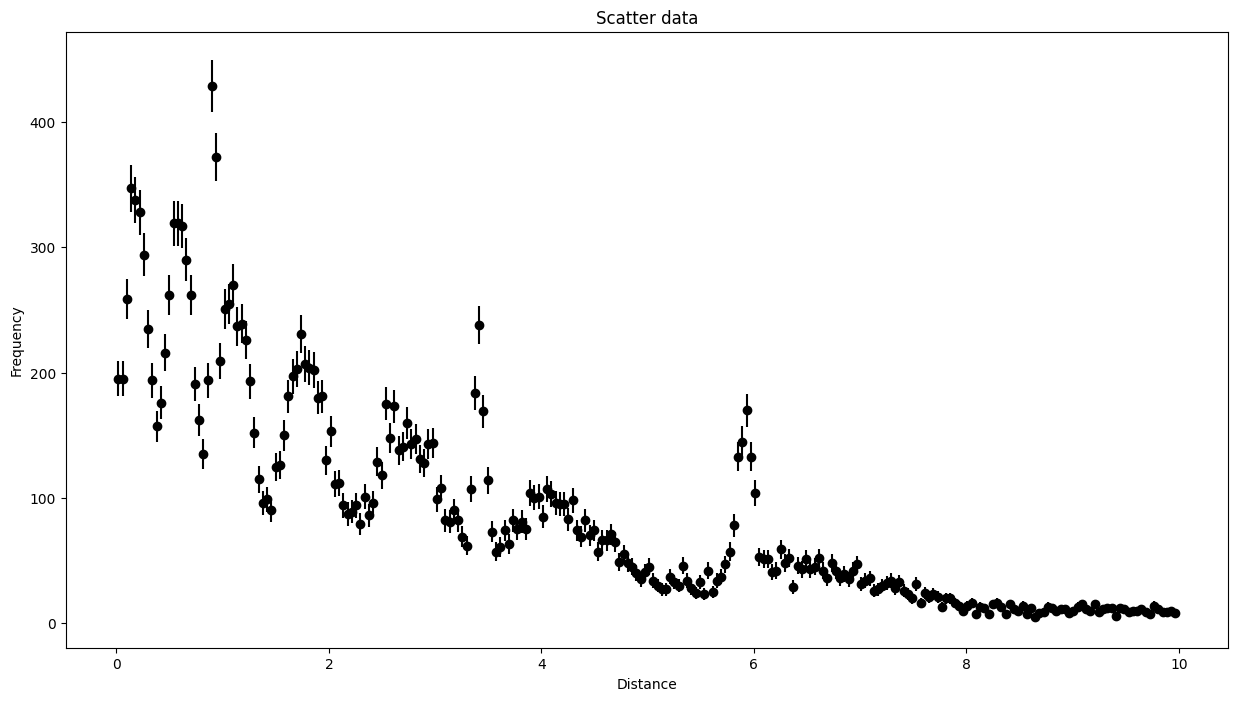

In [392]:
Scatter_data = pd.read_csv('data_InconstantBackground.csv')
Distance = Scatter_data['# Distance']

#Plot the data and test to what extend the background in the range [8,10] is uniform.
print(len(Distance))
z_scores = stats.zscore(Distance)
print(z_scores)
# Distance = Distance[(z_scores < 1.5) | (Distance > 2)]
print(len(Distance))

xmin,xmax = distance.min(), distance.max()

Nbins = 250

counts, edges = np.histogram(Distance, bins=Nbins)
x = (edges[1:] + edges[:-1])/2
y = counts
yerr = np.sqrt(y)

fig, ax = plt.subplots(figsize=(15, 8))
ax.errorbar(x, y, yerr=yerr, fmt='o', color='black', label='Data')
ax.set_xlabel('Distance')
ax.set_ylabel('Frequency')
ax.set_title('Scatter data')
plt.show()

#test to what extend the background in the range [8,10] is uniform
def uniform(x, mean):
    return np.ones_like(x)*mean




Chi2/ndf for uniform distribution: 0.94 p = 0.55

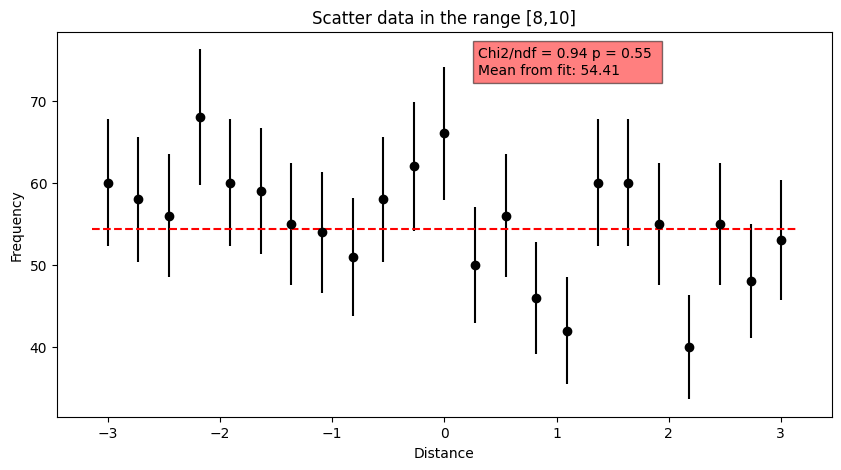

In [393]:
Distance_810 = Distance[(Distance >= 8) & (Distance <= 10)]
Nbins_810 = int(np.sqrt(len(Distance_810)))
#int(np.sqrt(len(Distance_810)))

def uniform(x, mean):
    # k = (2*np.pi)/int(np.sqrt(len(x)))
    # N_norm = k*len(x)
    return np.ones_like(x)*mean
    
#chi2 Uniform
counts, edges = np.histogram(phi, bins=Nbins_810)
x = (edges[1:] + edges[:-1])/2
x = x[counts > 0]
y = counts[counts > 0]
yerr = np.sqrt(y)

fig1,ax1 = plt.subplots(figsize=(10, 5))
ax1.errorbar(x, y, yerr=yerr, fmt='o', color='black', label='Data')
ax1.set_xlabel('Distance')
ax1.set_ylabel('Frequency')
ax1.set_title('Scatter data in the range [8,10]')


fit_uni = cost.LeastSquares(x, y, yerr, uniform)
m_uni = Minuit(fit_uni, mean = 1/(3+3))
m_uni.migrad()
MeanFit = m_uni.values['mean']
chi2_uniform = m_uni.fval
ndf = len(x) - 1
p = stats.chi2.sf(chi2_uniform, ndf)
print(f'Chi2/ndf for uniform distribution: {chi2_uniform/ndf:.2f} p = {p:.2f}')
x_uniform = np.linspace(-np.pi, np.pi, 1000)
y_uniform = uniform(x_uniform, m_uni.values['mean'])

ax1.plot(x_uniform, y_uniform, color='red', linestyle='--', label='Uniform distribution fitted')
ax1.text(0.25, 0.5, f'Chi2/ndf = {chi2_uniform/ndf:.2f} p = {p:.2f} \nMean from fit: {MeanFit:.2f}', transform=ax.transAxes,
           bbox=dict(facecolor='red', alpha=0.5))
ax.legend()
plt.show()

With a p-value of 0.55 and a good chi2/ndof I can say that the data is consistent with being uniform, since I cannot reject the Null Hypothesis that the data in the range [8,10] is uniform, and the mean of the freqeuency is seems consistent with the plot. I see that there is some deviation around the peak at 1, which makes it hard to fit a guassing peak. It looks like from the data, that two peaks are very close to each other, with one peak deviating a lot from the rest of the data. I first tried to calculate some z-values for the range [0,2] and remove any outliers that way, but that didn't seem to work. There is also some high correlation between the parameters A and k, but below 0.85, so I will keep them both in the fit. I ended up masking the range of the fit, to ensure I fitted to the peak visible in the data.


Chi2/ndf for Gaussian peaks: 4.89 p = 0.00


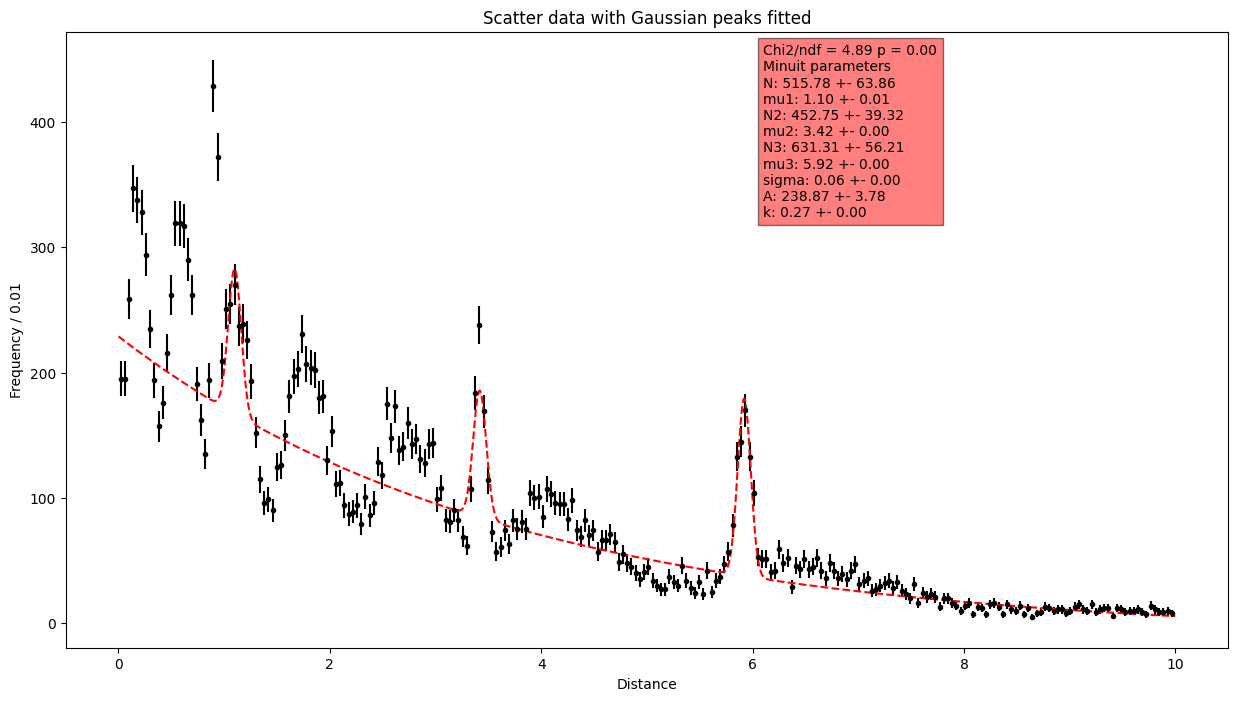

In [394]:

binwidth_gauss = (xmax-xmin)/Nbins

# def Gauss_peaks(x, N, mu1, N2, mu2, N3, mu3, sigma, A, k):
#     norm = binwidth_gauss/ np.sqrt(2.0*np.pi) / sigma
#     z1 = (x - mu1)/sigma
#     z2 = (x - mu2)/sigma
#     z3 = (x - mu3)/sigma
    

#     return norm*(N*np.exp(-0.5*z1**2) + N2*np.exp(-0.5*z2**2) + N3*np.exp(-0.5*z3**2)) + A*np.exp(-k*x)

def Gauss_peaks(x, N, mu1, N2, mu2, N3, mu3, sigma, A, k):
    norm = binwidth_gauss/ np.sqrt(2.0*np.pi) / sigma
    return norm*(stats.norm.pdf(x, mu1, sigma)*N + stats.norm.pdf(x, mu2, sigma)*N2 + stats.norm.pdf(x, mu3, sigma)*N3) + A*np.exp(-k*x) - 10

counts, edges = np.histogram(Distance, bins=Nbins)
x = (edges[1:] + edges[:-1])/2
y = counts
yerr = np.sqrt(y)

mask = (x > 0.94) & (x < 10)

fit = cost.LeastSquares(x[mask], y[mask], yerr[mask], Gauss_peaks)

Guess = {'N': 200, 'mu1': 0.91, 'N2': 200, 'mu2': 3.4, 'N3': 150, 'mu3': 5.9, 'sigma': 0.1, 'A': 200, 'k': 0.3}

m = Minuit(fit, **Guess)
m.migrad()


chi2 = m.fval
ndf = len(x) - len(m.values)
p = stats.chi2.sf(chi2, ndf)
print(f'Chi2/ndf for Gaussian peaks: {chi2/ndf:.2f} p = {p:.2f}')

x_fit = np.linspace(0, 10, 1000)
y_fit = Gauss_peaks(x_fit, m.values['N'], m.values['mu1'], m.values['N2'], m.values['mu2'], m.values['N3'], m.values['mu3'], m.values['sigma'], m.values['A'], m.values['k'])

fig, ax = plt.subplots(figsize=(15, 8))
ax.errorbar(x, y, yerr=yerr, fmt='.', color='black', label='Data')
ax.plot(x_fit, y_fit, color='red', linestyle='--', label='Gaussian peaks fitted')
ax.text(0.6, 0.7, f'Chi2/ndf = {chi2/ndf:.2f} p = {p:.2f}\nMinuit parameters \nN: {m.values["N"]:.2f} +- {m.errors["N"]:.2f} \nmu1: {m.values["mu1"]:.2f} +- {m.errors["mu1"]:.2f} \nN2: {m.values["N2"]:.2f} +- {m.errors["N2"]:.2f} \nmu2: {m.values["mu2"]:.2f} +- {m.errors["mu2"]:.2f} \nN3: {m.values["N3"]:.2f} +- {m.errors["N3"]:.2f} \nmu3: {m.values["mu3"]:.2f} +- {m.errors["mu3"]:.2f} \nsigma: {m.values["sigma"]:.2f} +- {m.errors["sigma"]:.2f} \nA: {m.values["A"]:.2f} +- {m.errors["A"]:.2f} \nk: {m.values["k"]:.2f} +- {m.errors["k"]:.2f}', transform=ax.transAxes,
           bbox=dict(facecolor='red', alpha=0.5))
ax.set_xlabel('Distance')
ax.set_ylabel(f'Frequency / {binwidth_gauss:.2f}')
ax.set_title('Scatter data with Gaussian peaks fitted')
plt.show()



To do this I will simply set some bounds for the peaks using the parameters from the fit (The mean and the standard deviation), to give me a number of points in the peaks and using the errors for the peaks given from minuit. Afterwards I will perform a z-test to see if the peaks are significantly different from each other. I will use a significance level of 0.05. Furthermore I will do a chi2-squared test to see if the data is consistent with having equal amount of entries in each, compared to the total amount of entries in the 3 peaks. I will use a significance level of 0.05.

As seen both they z-test and the chi2-squared test gives a p-value below 0.05, so I can reject the null hypothesis that the peaks are the same and that the data is consistent with having equal amount of entries in each peak.

In [395]:
lower_bound1 = m.values['mu1'] - m.values['sigma']
upper_bound1 = m.values['mu1'] + m.values['sigma']
lower_bound2 = m.values['mu2'] - m.values['sigma']
upper_bound2 = m.values['mu2'] + m.values['sigma']
lower_bound3 = m.values['mu3'] - m.values['sigma']
upper_bound3 = m.values['mu3'] + m.values['sigma']

# Entries_in_peak = control_freq[(control_freq > lower_bound) & (control_freq < upper_bound)].shape[0]
Entries_in_peak1 = Distance[(Distance > lower_bound1) & (Distance < upper_bound1)].shape[0]
Entries_in_peak2 = Distance[(Distance > lower_bound2) & (Distance < upper_bound2)].shape[0]
Entries_in_peak3 = Distance[(Distance > lower_bound3) & (Distance < upper_bound3)].shape[0]

print(f'Total entries = {Distance.shape[0]}')
print('')
print(f'Entries in peak 1: {Entries_in_peak1:.0f} +- {m.errors["N"]:.0f}')
print(f'Entries in peak 2: {Entries_in_peak2:.0f} +- {m.errors["N2"]:.0f}')
print(f'Entries in peak 3: {Entries_in_peak3:.0f} +- {m.errors["N3"]:.0f}')


#Testing if the have the same amount of entries in the peaks

def chi2_test(O,E, sigma):
    chi2 = np.sum((O - E)**2/sigma**2)
    p = stats.chi2.sf(chi2, len(O) - 1)
    return chi2, p


def two_sample_test(mu1,mu2,sig1,sig2):
    z = (mu1 - mu2)/np.sqrt(sig1**2 + sig2**2)
    p = stats.norm.sf(abs(z))
    return z,p

O = np.array([Entries_in_peak1, Entries_in_peak2, Entries_in_peak3])
E = np.full(3, np.sum(O)/3)
E_err = np.array([m.errors['N'], m.errors['N2'], m.errors['N3']])

chi2, p = chi2_test(O, E, E_err)
print(f'Chi2 for the entries in the peaks: {chi2:.2f} p = {p:.2f}')

z12, p12 = two_sample_test(O[0], O[1], E_err[0], E_err[1])
z13, p13 = two_sample_test(O[0], O[2], E_err[0], E_err[2])
z23, p23 = two_sample_test(O[1], O[2], E_err[1], E_err[2])

print(f'z12 = {z12:.2f} p = {p12:.2f}')
print(f'z13 = {z13:.2f} p = {p13:.2f}')
print(f'z23 = {z23:.2f} p = {p23:.2f}')




Total entries = 21933

Entries in peak 1: 785 +- 64
Entries in peak 2: 602 +- 39
Entries in peak 3: 465 +- 56
Chi2 for the entries in the peaks: 14.39 p = 0.00
z12 = 2.44 p = 0.01
z13 = 3.76 p = 0.00
z23 = 2.00 p = 0.02


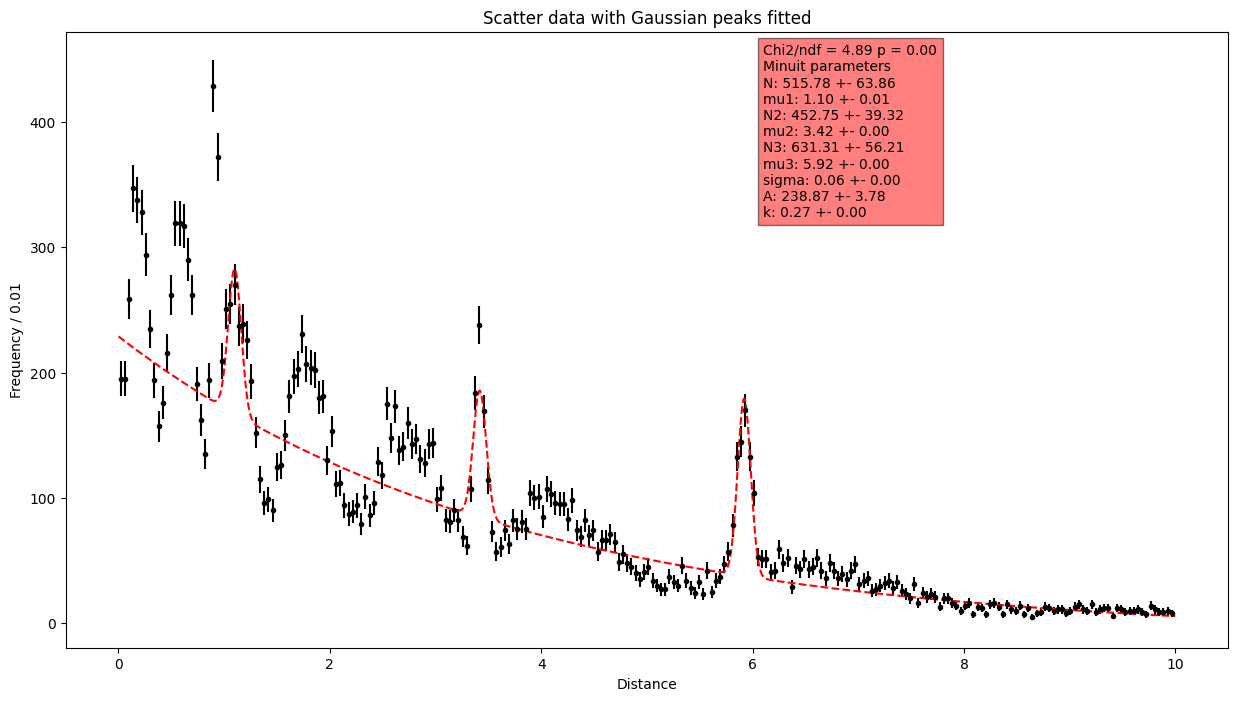

In [396]:
fig

Chi2/ndf for Gaussian peaks: 6.22 p = 0.00


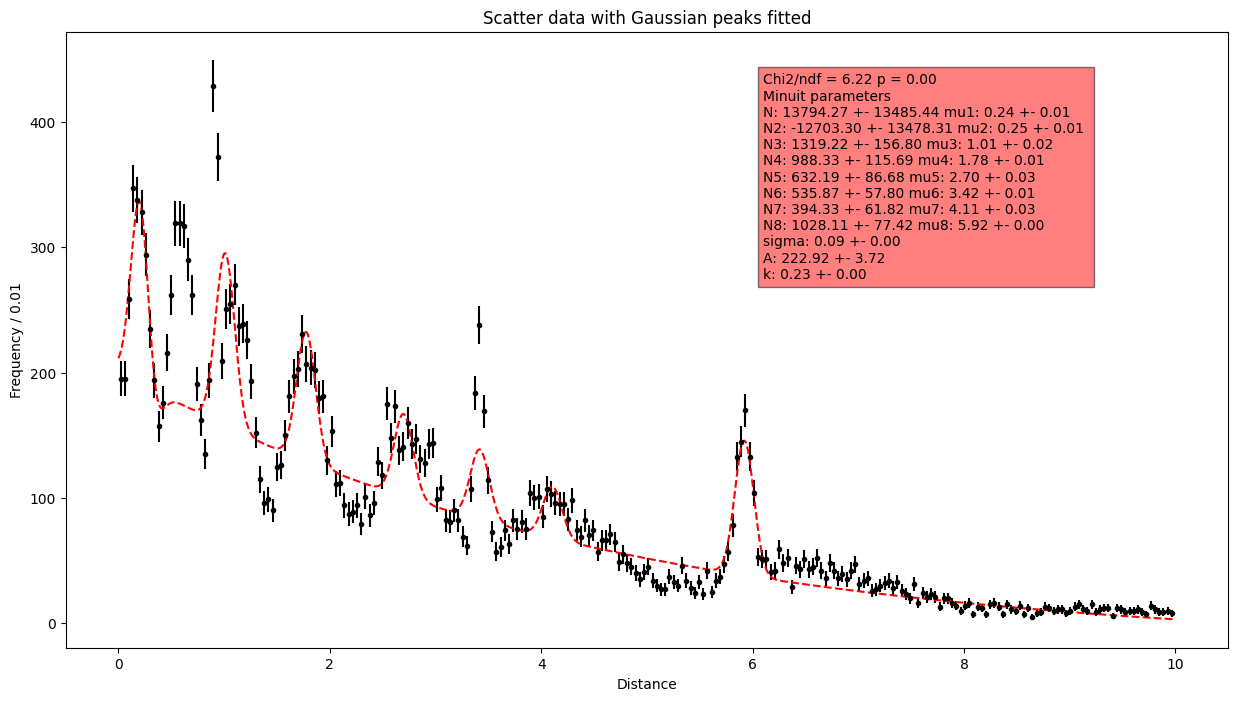

In [397]:
def Gauss_peaks(x, N, mu1, N2, mu2, N3, mu3, N4, mu4, N5, mu5, N6, mu6, N7, mu7, N8, mu8, sigma, A, k):
    norm = binwidth_gauss/ np.sqrt(2.0*np.pi) / sigma
    return norm*(stats.norm.pdf(x, mu1, sigma)*N + stats.norm.pdf(x, mu2, sigma)*N2 
                + stats.norm.pdf(x, mu3, sigma)*N3 + stats.norm.pdf(x, mu4, sigma)*N4 
                + stats.norm.pdf(x, mu5, sigma)*N5 + stats.norm.pdf(x, mu6, sigma)*N6 
                + stats.norm.pdf(x, mu7, sigma)*N7 + stats.norm.pdf(x, mu8, sigma)*N8) + A*np.exp(-k*x) - 20

counts, edges = np.histogram(Distance, bins=Nbins)
x = (edges[1:] + edges[:-1])/2
y = counts
yerr = np.sqrt(y)

mask =(x > 0.94) & (x < 10)

# fit = cost.LeastSquares(x[mask], y[mask], yerr[mask], Gauss_peaks)
fit = cost.LeastSquares(x, y, yerr, Gauss_peaks)

Guess = {'N': 350, 'mu1': 0.1, 'N2': 320, 'mu2': 0.2, 'N3': 200, 'mu3': 0.91, 'N4': 200,
        'mu4':1.9, 'N5': 180, 'mu5': 2.3, 'N6': 200, 'mu6': 3.4, 'N7': 100, 'mu7':4, 'N8': 150, 'mu8': 5.9,   
        'sigma': 0.1, 'A': 200, 'k': 0.3}

m = Minuit(fit, **Guess)
m.migrad()

chi2 = m.fval
ndf = len(x) - len(m.values)
p = stats.chi2.sf(chi2, ndf)
print(f'Chi2/ndf for Gaussian peaks: {chi2/ndf:.2f} p = {p:.2f}')

x_fit = np.linspace(0, 10, 1000)
y_fit = Gauss_peaks(x_fit, m.values['N'], m.values['mu1'], m.values['N2'], m.values['mu2'], m.values['N3'], m.values['mu3'], m.values['N4'], m.values['mu4'], m.values['N5'], m.values['mu5'], m.values['N6'], m.values['mu6'], m.values['N7'], m.values['mu7'], m.values['N8'], m.values['mu8'], m.values['sigma'], m.values['A'], m.values['k'])

fig, ax = plt.subplots(figsize=(15, 8))
ax.errorbar(x, y, yerr=yerr, fmt='.', color='black', label='Data')
ax.plot(x_fit, y_fit, color='red', linestyle='--', label='Gaussian peaks fitted')
ax.text(0.6, 0.6, f'Chi2/ndf = {chi2/ndf:.2f} p = {p:.2f}\nMinuit parameters \nN: {m.values["N"]:.2f} +- {m.errors["N"]:.2f} mu1: {m.values["mu1"]:.2f} +- {m.errors["mu1"]:.2f} \nN2: {m.values["N2"]:.2f} +- {m.errors["N2"]:.2f} mu2: {m.values["mu2"]:.2f} +- {m.errors["mu2"]:.2f} \nN3: {m.values["N3"]:.2f} +- {m.errors["N3"]:.2f} mu3: {m.values["mu3"]:.2f} +- {m.errors["mu3"]:.2f} \nN4: {m.values["N4"]:.2f} +- {m.errors["N4"]:.2f} mu4: {m.values["mu4"]:.2f} +- {m.errors["mu4"]:.2f} \nN5: {m.values["N5"]:.2f} +- {m.errors["N5"]:.2f} mu5: {m.values["mu5"]:.2f} +- {m.errors["mu5"]:.2f} \nN6: {m.values["N6"]:.2f} +- {m.errors["N6"]:.2f} mu6: {m.values["mu6"]:.2f} +- {m.errors["mu6"]:.2f} \nN7: {m.values["N7"]:.2f} +- {m.errors["N7"]:.2f} mu7: {m.values["mu7"]:.2f} +- {m.errors["mu7"]:.2f} \nN8: {m.values["N8"]:.2f} +- {m.errors["N8"]:.2f} mu8: {m.values["mu8"]:.2f} +- {m.errors["mu8"]:.2f} \nsigma: {m.values["sigma"]:.2f} +- {m.errors["sigma"]:.2f} \nA: {m.values["A"]:.2f} +- {m.errors["A"]:.2f} \nk: {m.values["k"]:.2f} +- {m.errors["k"]:.2f}', transform=ax.transAxes,
              bbox=dict(facecolor='red', alpha=0.5))
ax.set_xlabel('Distance')
ax.set_ylabel(f'Frequency / {binwidth_gauss:.2f}')
ax.set_title('Scatter data with Gaussian peaks fitted')
plt.show()

The reduced chi2 of 6.22 most likely indicates a significant deviation from the model used, which is also seen in the model, as one of the peaks was not fitted. Some improvements that could have been made, is to revaluate some of the outliers, as they seem to impact the fit for the second peak seen in the figure. Maybe even try to look at overlapping gaussians, as the peaks are very close to each other, and therefore their parameters are correlated, as I from the covariance matrix from minuit.

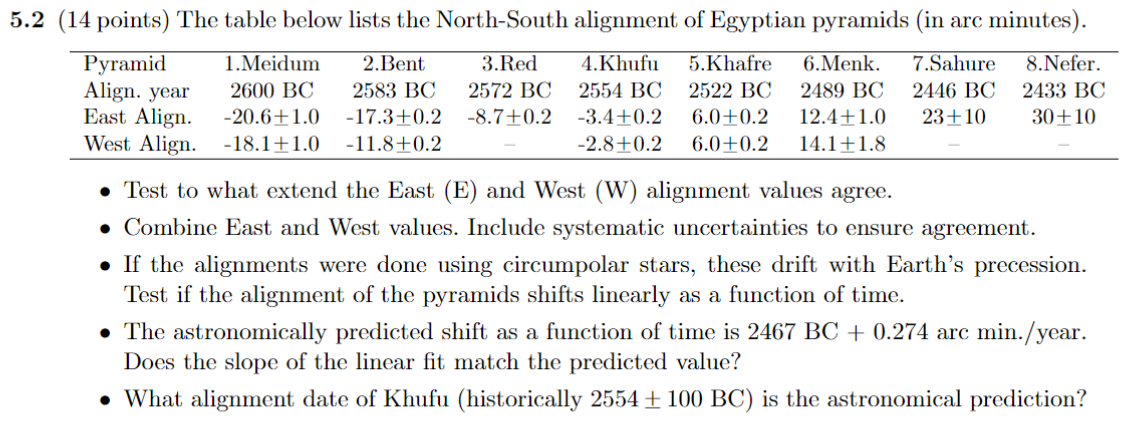

For the ones where there is no allignment, I have replaced the NaN with 0. I will then use the t-test, as we have a low number statestics, with the amount of data points, to see if the East and West allignment values agree with each other. I will use a significance level of 0.05.

In [398]:
data = {
    "Pyramid": ["Meidum", "Bent", "Red", "Khufu", "Khafre", "Menk", "Sahure", "Nefer"],
    "Align_year_BC": [2600, 2583, 2572, 2554, 2522, 2489, 2446, 2433],
    "East_Align": [-20.6, -17.3, -8.7, -3.4, 6.0, 12.4, 23, 30],
    "East_Align_unc": [1.0, 0.2, 0.2, 0.2, 0.2, 1.0, 10, 10],
    "West_Align": [-18.1, -11.8, None, -2.8, 6.0, 14.1, None, None],
    "West_Align_unc": [1.0, 0.2, None, 0.2, 0.2, 1.8, None, None]
}

data = pd.DataFrame(data)
data = data.replace(np.nan, 0)

difference_align = data['East_Align'] - data['West_Align']
difference_align_unc = np.sqrt(data['East_Align_unc']**2 + data['West_Align_unc']**2)

def t_test(x, y, sigma_x, sigma_y):
    z = (x - y)/np.sqrt(sigma_x**2 + sigma_y**2)
    p = stats.norm.sf(abs(z))
    return z, p

z, p = t_test(data['East_Align'], data['West_Align'], data['East_Align_unc'], data['West_Align_unc'])
for i in range(len(data)):
    if data['West_Align'][i] == 0:
        print(data["Pyramid"][i],': Has no data for West alignment')
    else:
        print(f'{data["Pyramid"][i]}: z = {z[i]:.2f}, p = {p[i]:.2f}')


Meidum: z = -1.77, p = 0.04
Bent: z = -19.45, p = 0.00
Red : Has no data for West alignment
Khufu: z = -2.12, p = 0.02
Khafre: z = 0.00, p = 0.50
Menk: z = -0.83, p = 0.20
Sahure : Has no data for West alignment
Nefer : Has no data for West alignment


I will use a weighted average for each of the pyramids to include the systematic uncertainties and find the combined alligment with errors

In [399]:
#Combine East and West values (Done using code found online)
data['Combined_Align'] = [
    weighted(
        [data['East_Align'][i], data['West_Align'][i]],
        [data['East_Align_unc'][i], data['West_Align_unc'][i]]
    ) if data['West_Align'][i] != 0 else (data['East_Align'][i], data['East_Align_unc'][i])
    for i in range(len(data))
]

print(data['Pyramid'])
print(data['Combined_Align'])

0    Meidum
1      Bent
2       Red
3     Khufu
4    Khafre
5      Menk
6    Sahure
7     Nefer
Name: Pyramid, dtype: object
0                  (-19.35, 0.7071067811865475)
1    (-14.549999999999999, 0.14142135623730953)
2                                   (-8.7, 0.2)
3                   (-3.1, 0.14142135623730953)
4                    (6.0, 0.14142135623730953)
5      (12.800943396226415, 0.8741572761215377)
6                                  (23.0, 10.0)
7                                  (30.0, 10.0)
Name: Combined_Align, dtype: object


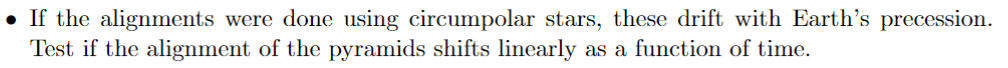

Here it is important to note that since my values of x (year) is far from 0, it will most likely cause a lot of correlation between the a and b (parameters), as a small change in a, will cause a big change in b. To counter this I will substract the average year from x.

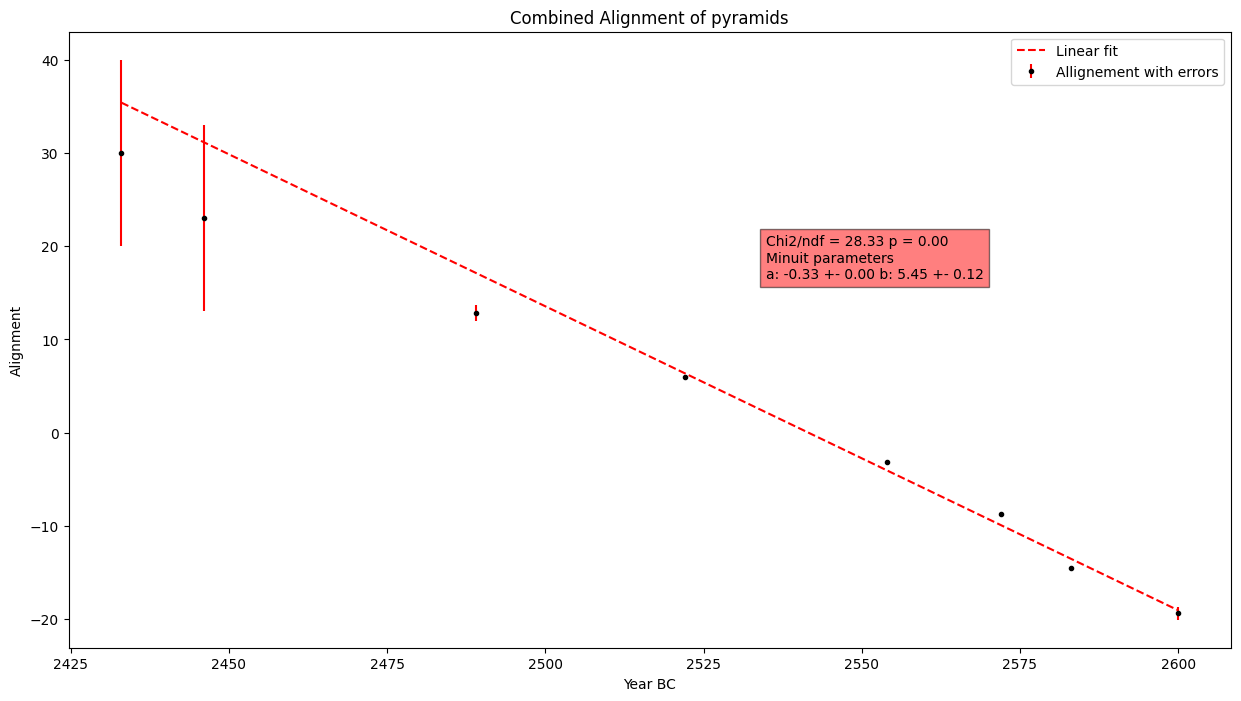

In [400]:
xminyear = data['Align_year_BC'].min()
xmaxyear = data['Align_year_BC'].max()

xmean = np.mean(data['Align_year_BC'])

def linear(x, a, b):
    return a*(x - xmean) + b


comb_align = np.array([])
comb_align_err = np.array([])
for i in range(len(data)):
    comb_align = np.append(comb_align, data['Combined_Align'][i][0])
    comb_align_err = np.append(comb_align_err, data['Combined_Align'][i][1])


fit = cost.LeastSquares(data['Align_year_BC'], comb_align, comb_align_err, linear)

mfit = Minuit(fit, a = -10, b = 30)
mfit.migrad()

chi2 = mfit.fval
ndf = len(data) - 2
p = stats.chi2.sf(chi2, ndf)

a = mfit.values['a']
b = mfit.values['b']

x_fit = np.linspace(xminyear, xmaxyear, 1000)
y_fit = linear(x_fit, a, b)

fig, ax = plt.subplots(figsize=(15, 8))
ax.errorbar(data['Align_year_BC'], comb_align, yerr=comb_align_err, fmt='.', color='black',ecolor = 'red', label='Allignement with errors')
ax.plot(x_fit, y_fit, color='red', linestyle='--', label='Linear fit')
ax.text(0.6, 0.6, f'Chi2/ndf = {chi2/ndf:.2f} p = {p:.2f}\nMinuit parameters \na: {mfit.values["a"]:.2f} +- {mfit.errors["a"]:.2f} b: {mfit.values["b"]:.2f} +- {mfit.errors["b"]:.2f}', transform=ax.transAxes,
                bbox=dict(facecolor='red', alpha=0.5))
ax.set_xlabel('Year BC')
ax.set_ylabel('Alignment')
ax.set_title('Combined Alignment of pyramids')
ax.legend()
plt.show()


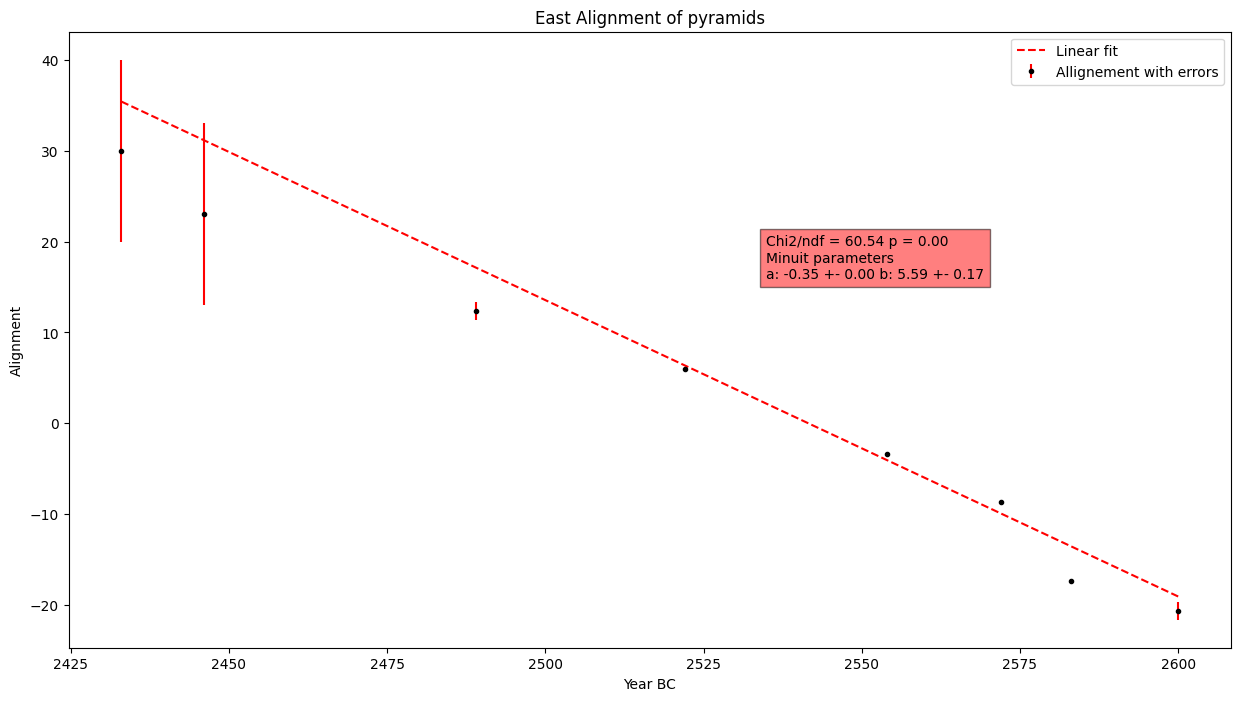

In [401]:
xminyear = data['Align_year_BC'].min()
xmaxyear = data['Align_year_BC'].max()

xmean = np.mean(data['Align_year_BC'])

def linear(x, a, b):
    return a*(x - xmean) + b


comb_align_E = np.array([])
comb_align_err_E = np.array([])
for i in range(len(data)):
    comb_align_E = np.append(comb_align_E, data["East_Align"][i])
    comb_align_err_E = np.append(comb_align_err_E, data['East_Align_unc'][i])



fit_E = cost.LeastSquares(data['Align_year_BC'], comb_align_E, comb_align_err_E, linear)

mfit_E = Minuit(fit_E, a = -10, b = 30)
mfit_E.migrad()

chi2_E = mfit_E.fval
ndf_E = len(data) - 2
p_E = stats.chi2.sf(chi2_E, ndf_E)

a_E = mfit_E.values['a']
b_E = mfit_E.values['b']

x_fit_E = np.linspace(xminyear, xmaxyear, 1000)
y_fit_E = linear(x_fit_E, a, b)

fig, ax = plt.subplots(figsize=(15, 8))
ax.errorbar(data['Align_year_BC'], comb_align_E, yerr=comb_align_err_E, fmt='.', color='black',ecolor = 'red', label='Allignement with errors')
ax.plot(x_fit_E, y_fit_E, color='red', linestyle='--', label='Linear fit')
ax.text(0.6, 0.6, f'Chi2/ndf = {chi2_E/ndf_E:.2f} p = {p_E:.2f}\nMinuit parameters \na: {mfit_E.values["a"]:.2f} +- {mfit_E.errors["a"]:.2f} b: {mfit_E.values["b"]:.2f} +- {mfit_E.errors["b"]:.2f}', transform=ax.transAxes,
                bbox=dict(facecolor='red', alpha=0.5))
ax.set_xlabel('Year BC')
ax.set_ylabel('Alignment')
ax.set_title('East Alignment of pyramids')
ax.legend()
plt.show()

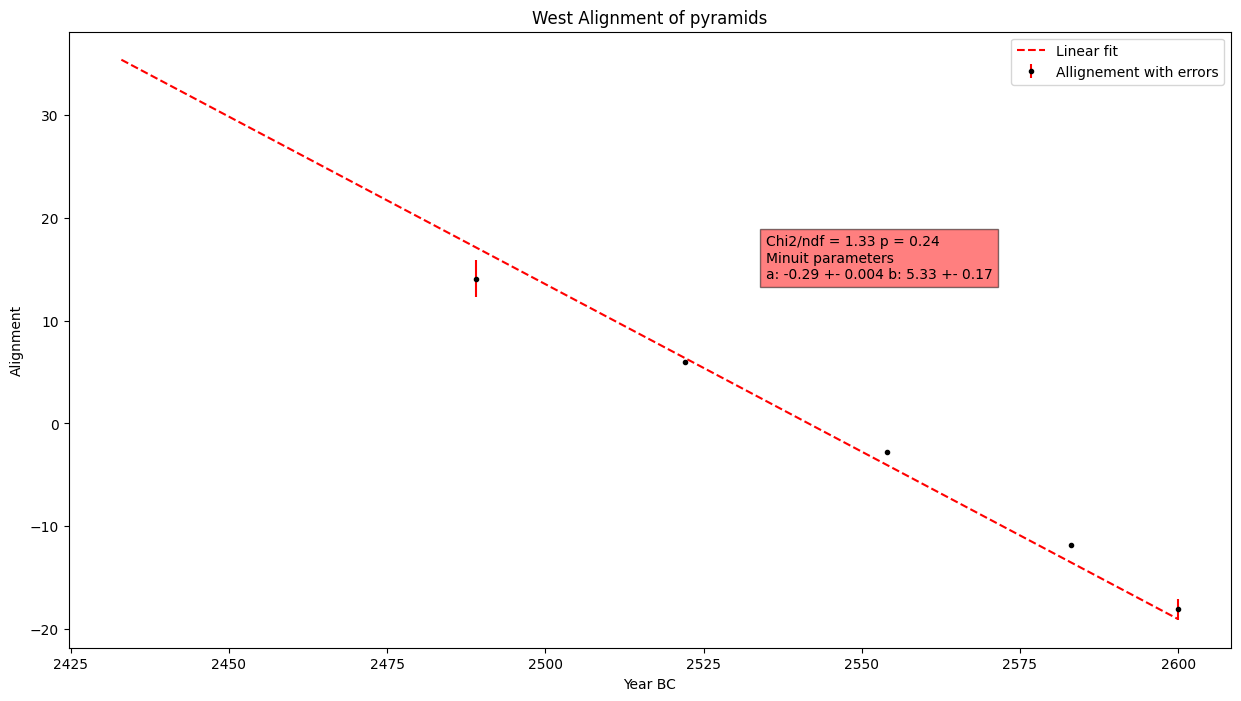

In [421]:
xminyear = data['Align_year_BC'].min()
xmaxyear = data['Align_year_BC'].max()

xmean = np.mean(data['Align_year_BC'])

def linear(x, a, b):
    return a*(x - xmean) + b


comb_align_w = np.array([])
comb_align_err_w = np.array([])
for i in range(len(data)):
    comb_align_w = np.append(comb_align_w, data["West_Align"][i])
    comb_align_err_w = np.append(comb_align_err_w, data['West_Align_unc'][i])

mask_w = comb_align_w != 0
comb_align_w = comb_align_w[mask_w]
comb_align_err_w = comb_align_err_w[mask_w]
alignyear = data['Align_year_BC'][mask_w]


fit_W = cost.LeastSquares(alignyear, comb_align_w, comb_align_err_w, linear)

mfit_w = Minuit(fit_W, a = -10, b = 30)
mfit_w.migrad()

chi2_w = mfit_w.fval
ndf_w = len(data) - 2
p_w = stats.chi2.sf(chi2_w, ndf_w)

a_w = mfit_w.values['a']
b_w = mfit_w.values['b']

x_fit_w = np.linspace(xminyear, xmaxyear, 1000)
y_fit_w = linear(x_fit_w, a_w, b_w)

fig, ax = plt.subplots(figsize=(15, 8))
ax.errorbar(alignyear, comb_align_w, yerr=comb_align_err_w, fmt='.', color='black',ecolor = 'red', label='Allignement with errors')
ax.plot(x_fit, y_fit, color='red', linestyle='--', label='Linear fit')
ax.text(0.6, 0.6, f'Chi2/ndf = {chi2_w/ndf_w:.2f} p = {p_w:.2f}\nMinuit parameters \na: {mfit_w.values["a"]:.2f} +- {mfit_w.errors["a"]:.3f} b: {mfit_w.values["b"]:.2f} +- {mfit_w.errors["b"]:.2f}', transform=ax.transAxes,
                bbox=dict(facecolor='red', alpha=0.5))
ax.set_xlabel('Year BC')
ax.set_ylabel('Alignment')
ax.set_title('West Alignment of pyramids')
ax.legend()
plt.show()

A lot of the points lie outside of a 3 sigma range, as to why I also get a very low p-value (Could be a underestimation of uncertainties, if it is truly linear). I could look into removing some outliers, but as I deem all points relevant, with the low number of data points, I will keep them in the fit. At first glance the parameters look a bit off for the value of b, but as b is the intercept, it fits the data well.

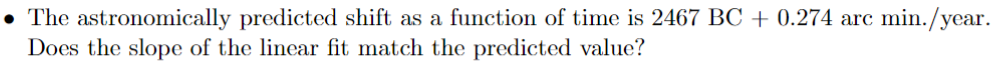

The slope of my fits should be equal to the shift as a function of time, so I will compare the 3 slopes to the real value and evaluate using a z-test and chi2-test to see if they are consistent with each other. I will use a significance level of 0.05.

In [412]:
real_shift = 0.274
west_shift = -a_w 
west_shift_error = mfit_w.errors['a']
east_shift = -a_E
east_shift_error = mfit_E.errors['a']
combined_shift = -a
combined_shift_error = mfit.errors['a']
def z_test(x, y, sigma_x):
    z = (x - y)/sigma_x
    p = stats.norm.sf(abs(z))
    return z, p

def chi2_test(O,E, sigma):
    chi2 = (O - E)**2/sigma**2
    p = stats.chi2.sf(chi2, 1)
    return chi2, p

z_west, p_west = z_test(west_shift, real_shift, west_shift_error)
z_east, p_east = z_test(east_shift, real_shift, east_shift_error)
z_comb, p_comb = z_test(combined_shift, real_shift, combined_shift_error)

chi2_west, p_west_chi = chi2_test(west_shift, real_shift, west_shift_error)
chi2_east, p_east_chi = chi2_test(east_shift, real_shift, east_shift_error)
chi2_comb, p_comb_chi = chi2_test(combined_shift, real_shift, combined_shift_error)

print('z-test')
print(f'Combined shift: z = {z_comb:.2f} p = {p_comb:.2f}')
print(f'East shift: z = {z_east:.2f} p = {p_east:.2f}')
print(f'West shift: z = {z_west:.2f} p = {p_west:.2f}')
print('')

print('chi2-test')
print(f'Combined shift: chi2 = {chi2_comb:.2f} p = {p_comb_chi:.2f}')
print(f'East shift: chi2 = {chi2_east:.2f} p = {p_east_chi:.2f}')
print(f'West shift: chi2 = {chi2_west:.2f} p = {p_west_chi:.2f}')




z-test
Combined shift: z = 17.32 p = 0.00
East shift: z = 18.56 p = 0.00
West shift: z = 4.09 p = 0.00

chi2-test
Combined shift: chi2 = 299.87 p = 0.00
East shift: chi2 = 344.34 p = 0.00
West shift: chi2 = 16.70 p = 0.00


None of them are within 3 sigma of the real value, but it is clearly to see the deviation comes from the east shift, as the west shift by itself is almost within 4 sigma of the real value, so an argument could be made that it is consistent to some degree with the real value.

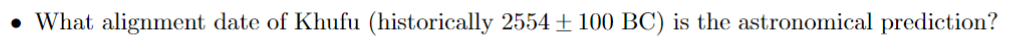

I will the value of Khufu's allignment both for the combined shift and the west and east seperatly to see which one is the most consistent with the real value. I will use a z-test and chi2-test to see if they are consistent with each other. I will use a significance level of 0.05. Furthermore I will use both the value of my fit and the given value in the assignemnt .

In [430]:
b_C = mfit.values['b']
b_E = mfit_E.values['b']
b_w = mfit_w.values['b']

a = real_shift
a_fit_C = mfit.values['a']

a_fit_w = mfit_w.values['a']

a_fit_E = mfit_E.values['a']

def year(allignment, a, b):
    return (allignment - b)/a + xmean

def year_error(allignment, a, b, sigma_a, sigma_b):
    return np.sqrt((((allignment - b)/a**2)*sigma_a)**2 + (sigma_b/a)**2)

Khufu_combined = data['Combined_Align'][3][0]
Khufu_combined_err = data['Combined_Align'][3][1]

Khufu_east = data['East_Align'][3]
Khufu_east_err = data['East_Align_unc'][3]

Khufu_west = data['West_Align'][3]
Khufu_west_err = data['West_Align_unc'][3]

year_combined = year(Khufu_combined, a_fit_C, b_C)
year_combined_err = year_error(Khufu_combined, a_fit_C, b_C, mfit.errors['a'], mfit.errors['b'])
print(f'Khufu combined: {year_combined:.2f} +- {year_combined_err:.2f}')

year_east = year(Khufu_east, a, b)
year_east_err = year_error(Khufu_east, a_fit_E, b_E, mfit_E.errors['a'], mfit_E.errors['b'])
print(f'Khufu east: {year_east:.2f} +- {year_east_err:.2f}')

year_west = year(Khufu_west, a, b)
year_west_err = year_error(Khufu_west, a_fit_w, b_w, mfit_w.errors['a'], mfit_w.errors['b'])
print(f'Khufu west: {year_west:.2f} +- {year_west_err:.2f}')

year_real = year(Khufu_combined, a, b_C)
year_real_err = year_error(Khufu_combined, a, b_C, mfit.errors['a'], mfit.errors['b'])
print(f'Khufu real: {year_real:.2f} +- {year_real_err:.2f}')





Khufu combined: 2551.09 +- 0.44
Khufu east: 2492.59 +- 0.56
Khufu west: 2494.78 +- 0.72
Khufu real: 2493.69 +- 0.55


It seems I'm getting really low uncertainties on the values, which is a bit odd, as I would expect them to be higher. This can make it a bit harder to compare to the historical value. Instead I will use the uncertainty on the historical value on my values, to see if they are consistent with each other. I realize this is not optimal, as I suspect my uncertainties should have been much higher on the year of alligmenent. I will use a significance level of 0.05.

In [431]:
Historical_value = 2554
Historical_value_err = 100

chi2_combined, p_combined = chi2_test(Historical_value,year_combined , Historical_value_err)
chi2_east, p_east = chi2_test(Historical_value,year_east , Historical_value_err)
chi2_west, p_west = chi2_test(Historical_value,year_west , Historical_value_err)
chi2_real, p_real = chi2_test(Historical_value,year_real , Historical_value_err)

z_combined, p_combined_z = z_test(Historical_value,year_combined , Historical_value_err)
z_east, p_east_z = z_test(Historical_value,year_east , Historical_value_err)
z_west, p_west_z = z_test(Historical_value,year_west , Historical_value_err)
z_real, p_real_z = z_test(Historical_value,year_real , Historical_value_err)

print('Chi2 test')
print(f'Combined: chi2 = {chi2_combined:.2f} p = {p_combined:.2f}')
print(f'East: chi2 = {chi2_east:.2f} p = {p_east:.2f}')
print(f'West: chi2 = {chi2_west:.2f} p = {p_west:.2f}')
print(f'Real: chi2 = {chi2_real:.2f} p = {p_real:.2f}')

print('Z test')
print(f'Combined: z = {z_combined:.2f} p = {p_combined_z:.2f}')
print(f'East: z = {z_east:.2f} p = {p_east_z:.2f}')
print(f'West: z = {z_west:.2f} p = {p_west_z:.2f}')
print(f'Real: z = {z_real:.2f} p = {p_real_z:.2f}')



Chi2 test
Combined: chi2 = 0.00 p = 0.98
East: chi2 = 0.38 p = 0.54
West: chi2 = 0.35 p = 0.55
Real: chi2 = 0.36 p = 0.55
Z test
Combined: z = 0.03 p = 0.49
East: z = 0.61 p = 0.27
West: z = 0.59 p = 0.28
Real: z = 0.60 p = 0.27


Doing it this way will ofcourse give me some good p-values, but still can be used to see how the different values compare, as here it looks like the combined value is the most consistent with the historical value.